# Implémentation et expérimentation de l'algorithme de construction d'arbres monotones
# Partie A : expérimentation des mesures de discrimination

In [2]:
import numpy as np
import pandas as pd
import math
import random
from utils import *
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Création de la base jouet :

In [3]:
training_set = LabeledSet(2)

for i in range(0, 3):
    training_set.addExample([random.randint(0,2),random.randint(0,10)],1)
for i in range(0, 3):
    training_set.addExample([random.randint(3, 5), random.randint(0, 10)], 2)
for i in range(0, 4):
    training_set.addExample([random.randint(6, 10), random.randint(0,10)], 3)

In [4]:
df = pd.DataFrame(training_set.x, columns=['x1', 'x2'])
df['label'] = training_set.y
df

,x1,x2,label
0,1,4,1
1,0,9,1
2,2,2,1
3,3,3,2
4,3,1,2
5,3,5,2
6,6,3,3
7,8,5,3
8,6,0,3
9,10,7,3


### Ensembles dominants générés par un attribut/label

In [91]:
def dominant_sets_attribute(a_j, labeled_set):    
    '''
        a_j : index of attribute in labeled_set
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by a_j  
    '''
    values = labeled_set.x.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))

    dominant_sets = dict()
    for i in range(0, labeled_set.size()):
        v = labeled_set.getX(i)[a_j]
        dominant_sets[i] = values[values[:,a_j] >= v][:,labeled_set.getInputDimension()]
            
    return dominant_sets

def dominant_sets_label(labeled_set):
    '''
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by its label  
    '''
    values = labeled_set.y.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    
    for i in range(0, labeled_set.size()):
        v = labeled_set.getY(i)
        dominant_sets[i] = values[values[:,0] >= v][:,1]
                
    return dominant_sets
    
dsa_1 = dominant_sets_attribute(0, training_set)
dsa_2 = dominant_sets_attribute(1, training_set)
dsl = dominant_sets_label(training_set)

In [92]:
a_set = LabeledSet(3)
a_set.addExample([0, 0, 1], 0)
a_set.addExample([0, 1, 0], 1)
a_set.addExample([0, 1, 1], 1)
a_set.addExample([1, 0, 1], 2)

dsa_3 = dominant_sets_attribute(0, a_set)
df_dsa3 = pd.DataFrame(list(dsa_3.items())).drop(0, axis=1)
df_dsa3.columns = ['dominant set generated by first attribute']
df_dsa3

,dominant set generated by first attribute
0,"[0, 1, 2, 3]"
1,"[0, 1, 2, 3]"
2,"[0, 1, 2, 3]"
3,[3]


In [93]:
df_dsa1 = pd.DataFrame(list(dsa_1.items())).drop(0, axis=1)
df_dsa1.columns = ['dominant set generated by first attribute']
df_dsa1

,dominant set generated by first attribute
0,"[0, 2, 3, 4, 5, 6, 7, 8, 9]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,"[2, 3, 4, 5, 6, 7, 8, 9]"
3,"[3, 4, 5, 6, 7, 8, 9]"
4,"[3, 4, 5, 6, 7, 8, 9]"
5,"[3, 4, 5, 6, 7, 8, 9]"
6,"[6, 7, 8, 9]"
7,"[7, 9]"
8,"[6, 7, 8, 9]"
9,[9]


In [94]:
df_dsa2 = pd.DataFrame(list(dsa_2.items())).drop(0, axis=1)
df_dsa2.columns = ['dominant set generated by second attribute']
df_dsa2

,dominant set generated by second attribute
0,"[0, 1, 5, 7, 9]"
1,[1]
2,"[0, 1, 2, 3, 5, 6, 7, 9]"
3,"[0, 1, 3, 5, 6, 7, 9]"
4,"[0, 1, 2, 3, 4, 5, 6, 7, 9]"
5,"[1, 5, 7, 9]"
6,"[0, 1, 3, 5, 6, 7, 9]"
7,"[1, 5, 7, 9]"
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
9,"[1, 9]"


In [95]:
df_dsl = pd.DataFrame(list(dsl.items())).drop(0, axis=1)
df_dsl.columns = ['dominant set generated by label']
df_dsl

,dominant set generated by label
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
3,"[3, 4, 5, 6, 7, 8, 9]"
4,"[3, 4, 5, 6, 7, 8, 9]"
5,"[3, 4, 5, 6, 7, 8, 9]"
6,"[6, 7, 8, 9]"
7,"[6, 7, 8, 9]"
8,"[6, 7, 8, 9]"
9,"[6, 7, 8, 9]"


### Construction hiérarchique de mesures de discrimination

#### f-layer :

In [106]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = values[values[:,a_j] == v][:,labeled_set.getInputDimension()]

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = values[values[:,0] == v][:,1]

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = values[values[:,a_j] >= v][:,labeled_set.getInputDimension()]
            
        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = values[values[:,0] >= v][:,1]

        return dominant_sets

In [10]:
class F_layer_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, dsa, dsl, esa):
        raise NotImplementedError

In [11]:
class F_layer_non_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError

In [12]:
class Ds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = np.intersect1d(esa_i, esl_i)
        
        return intersection.size * 1.0 / esa_i.size

In [97]:
ds_2 = Ds()
ds_2_values = []
esa = ds_2.equal_sets_attribute(training_set, 1)
esl = ds_2.equal_sets_label(training_set)
for i in range(0, 10):
    ds_2_values.append(ds_2.value(i, training_set, esa, esl))
pd.DataFrame(ds_2_values, columns=['ds generated by second attribute'])

,ds generated by second attribute
0,1.0
1,1.0
2,1.0
3,0.5
4,1.0
5,0.5
6,0.5
7,0.5
8,1.0
9,1.0


$dsr(\omega_i)$ :

In [103]:
class Dsr(F_layer_rank):
    
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = np.intersect1d(dsa_i, dsl_i)
        
        return intersection.size * 1.0 / dsa_i.size

In [104]:
dsr_1 = Dsr()
dsr_1_values = []
dsa = dsr_1.dominant_sets_attribute(training_set, 0)
dsl = dsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_1_values.append(dsr_1.value(i, training_set, dsa, dsl, None))
pd.DataFrame(dsr_1_values, columns=['dsr generated by first attribute'])

,dsr generated by first attribute
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [105]:
dsr_2 = Dsr()
dsr_2_values = []
dsa = dsr_2.dominant_sets_attribute(training_set, 1)
dsl = dsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_2_values.append(dsr_2.value(i, training_set, dsa, dsl, None))
pd.DataFrame(dsr_2_values, columns=['dsr generated by second attribute'])

,dsr generated by second attribute
0,1.000000
1,1.000000
2,1.000000
3,0.714286
4,0.666667
5,0.750000
6,0.428571
7,0.500000
8,0.400000
9,0.500000


In [17]:
class Minds(F_layer_non_rank):
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        equal_set = esa[w_i]
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            l = (np.intersect1d(esa[w_h], esl[w_h]).size)
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / equal_set.size

In [18]:
minds_2 = Minds()
minds_2_values = []
esa = minds_2.equal_sets_attribute(training_set, 1)
esl = minds_2.equal_sets_label(training_set)

for i in range(0, 10):
    minds_2_values.append(minds_2.value(i,training_set, esa, esl))
pd.DataFrame(minds_2_values, columns=['minds generated by second attribute'])

,minds generated by second attribute
0,1.0
1,1.0
2,1.0
3,0.5
4,1.0
5,0.5
6,0.5
7,0.5
8,1.0
9,1.0


$mindsr(\omega_i)$

In [19]:
class Mindsr(F_layer_rank):  
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = dsa[w_i]
        equal_set = esa[w_i]
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            l = np.intersect1d(dsa[w_h], dsl[w_h]).size
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / dominant_set.size

In [20]:
mindsr_1 = Mindsr()
mindsr_1_values = []
dsa = mindsr_1.dominant_sets_attribute(training_set, 0)
dsl = mindsr_1.dominant_sets_label(training_set)
esa = mindsr_1.equal_sets_attribute(training_set, 0)

for i in range(0, 10):
    mindsr_1_values.append(mindsr_1.value(i,training_set, dsa, dsl, esa))
pd.DataFrame(mindsr_1_values, columns=['mindsr generated by first attribute'])

,mindsr generated by first attribute
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


$maxdsr(\omega_i)$

In [21]:
class Maxdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = dsa[w_i]
        equal_set = esa[w_i]
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            l = np.intersect1d(dsa[w_h], dsl[w_h]).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / dominant_set.size

In [22]:
class Maxds(F_layer_non_rank):

    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            l = np.intersect1d(esa[w_h], esl[w_h]).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / equal_set.size

$avgdsr(\omega_i)$

In [23]:
class Avgdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        dominant_set = dsa[w_i]
        equal_set = esa[w_i]

        for w_h in equal_set:
            s += np.intersect1d(dsa[w_h], dsl[w_h]).size
            
        return ((1.0/equal_set.size) * s) / (dominant_set.size * 1.0)

In [24]:
class Avgds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        equal_set = esa[w_i]

        for w_h in equal_set:
            s += np.intersect1d(esa[w_h], esl[w_h]).size
            
        return ((1.0/equal_set.size)* s) / (1.0 * equal_set.size)

In [25]:
avgdsr_2 = Avgdsr()
avgdsr_2_values = []
dsa = avgdsr_2.dominant_sets_attribute(training_set, 1)
dsl = avgdsr_2.dominant_sets_label(training_set)
esa = avgdsr_2.dominant_sets_attribute(training_set, 1)

for i in range(0, 10):
    avgdsr_2_values.append(avgdsr_2.value(i, training_set, dsa, dsl, esa))
pd.DataFrame(avgdsr_2_values, columns=['avgdsr generated by second attribute'])

,avgdsr generated by second attribute
0,0.480000
1,1.000000
2,0.437500
3,0.408163
4,0.419753
5,0.437500
6,0.408163
7,0.437500
8,0.380000
9,0.500000


In [26]:
avgds_2 = Avgds()
avgds_2_values = []

esa = avgds_2.equal_sets_attribute(training_set, 1)
esl = avgds_2.equal_sets_label(training_set)

for i in range(0, 10):
    avgds_2_values.append(avgds_2.value(i, training_set, esa, esl))
pd.DataFrame(avgds_2_values, columns=['avgds generated by second attribute'])

,avgds generated by second attribute
0,1.0
1,1.0
2,1.0
3,0.5
4,1.0
5,0.5
6,0.5
7,0.5
8,1.0
9,1.0


#### g-layer :

In [27]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError

In [28]:
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 

In [29]:
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

In [30]:
class Frac(G_layer):
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log(f_value) / f_value
        '''
        return -log(f_value, 2) / (1.0 * f_value)

#### h-layer :

In [31]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError

In [32]:
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

#### Rank Shannon discrimination measure $H^*_s(\lambda | a_j)$ :

In [33]:
def rsdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank shannon discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += -log(f_layer.value(i, labeled_set, dsa, dsl, None), 2)
    return (1.0/n)*H

In [34]:
dsr_shannon = Dsr()
dsa_1 = dsr_shannon.dominant_sets_attribute(training_set, 0)
dsl = dsr_shannon.dominant_sets_label(training_set)
dsa_2 = dsr_shannon.dominant_sets_attribute(training_set, 1)
print("Rank Shannon discrimination measure generated by first attribute : ", rsdm(dsr_shannon, training_set, dsa_1, dsl))
print("Rank shannon discrimination measure generated by second attribute : ", rsdm(dsr_shannon, training_set, dsa_2, dsl))

Rank Shannon discrimination measure generated by first attribute :  0.0
Rank shannon discrimination measure generated by second attribute :  0.6029747343394053


#### Rank Gini discrimination measure $H^*_G(\lambda | a_j)$

In [35]:
def rgdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank gini discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += 1-(f_layer.value(i, labeled_set, dsa, dsl, None))
    return (1.0/n)*H

In [36]:
dsr_gini = Dsr()
print("Rank Gini discrimination measure generated by first attribute : ", rgdm(dsr_gini, training_set, dsa_1, dsl))
print("Rank Gini discrimination measure generated by second attribute : ", rgdm(dsr_gini, training_set, dsa_2, dsl))

Rank Gini discrimination measure generated by first attribute :  0.0
Rank Gini discrimination measure generated by second attribute :  0.30404761904761907


#### Generic discrimination measure :

In [37]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set, a_j):
        g_f = []

        if (isinstance(self.f, F_layer_rank)):
            dsa = self.f.dominant_sets_attribute(labeled_set, a_j)
            dsl = self.f.dominant_sets_label(labeled_set)
            esa = self.f.equal_sets_attribute(labeled_set, a_j)

            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, dsa, dsl, esa)))
        else:
            esa = self.f.equal_sets_attribute(labeled_set, a_j)
            esl = self.f.equal_sets_label(labeled_set)
        
            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, esa, esl)))
        
        return self.h.value(g_f, labeled_set)

In [38]:
f_layer = Dsr()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Rank Shannon discrimination measure generated by second attribute : " , rsdm.value(training_set, 1))
print("Rank Gini discrimination measure generated by second attribute : " , rgdm.value(training_set, 1))

Rank Shannon discrimination measure generated by second attribute :  0.6029747343394052
Rank Gini discrimination measure generated by second attribute :  0.30404761904761907


In [39]:
f_layer = Ds()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

sdm = Gdm(h_layer, g_layer_shannon, f_layer)
gdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Conditional Shannon entropy generated by second attribute : " , sdm.value(training_set, 1))
print("Conditional Gini entropy generated by second attribute : " , gdm.value(training_set, 1))

Conditional Shannon entropy generated by second attribute :  0.4
Conditional Gini entropy generated by second attribute :  0.2


## Expérimentation de la fonction de discrétisation

In [40]:
def discretize(H, labeled_set, a_j):
    '''
        H : discrimation measure
        labeled_set : labeled set
        a_j : attribute to discretize
        return threshold which minimizes the entropy function H for given feature a_j, 
            along with minimum entropy value
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values according to attribute a_j
    
    # binary set : for each object w_i taken in ascending order of a_j value,
    # a_j(w_h) = 0 if a_j(w_h) <= a_j(w_i), 1 otherwise
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        current_label = labeled_set.getY(ind[i])
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        lookahead_label = labeled_set.getY(ind[i+1])
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead or current_label == lookahead_label:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

In [41]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

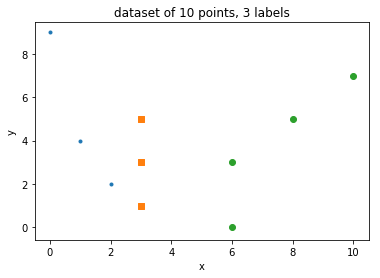

In [42]:
plot2DSet(training_set, "dataset of 10 points, 3 labels")

In [43]:
def display_discretization(labeled_set, threshold, a_j, title):
    '''
        labeled_set : labeled_set
        threshold : value of threshold 
        a_j : index of discretized attribute
        title : plot title
        
        display 2D database along with threshold generated by discretization on attribute a_j
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [44]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, real_thresholds, a_j, title, l1, l2):
    '''
        labeled_set : labeled_set
        threshold1 : threshold generated by discretization on a_j with first measure
        threshold2 : threshold generated by discretization on a_j with second measure
        real_thresholds : list of real thresholds
        title : plot title
        l1 : label of threshold1 (discrimination measure name)
        l2 : label of threshold2 (discrimination measure name)
        plot thresholds generated by two different discrimination measures on attribute a_j of labeled_set
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([threshold, threshold], [min_v, max_v], color='black', label="real threshold")
            else:
                plt.plot([threshold, threshold], [min_v, max_v], color='black')
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([min_v, max_v], [threshold, threshold], color='black', label="real threshold")
            else:
                plt.plot([min_v, max_v], [threshold, threshold], color='black')
    plt.legend()
    plt.show() 

In [45]:
def discretize_steps(H, labeled_set, a_j):
    '''
        a_j : index of attribute in labeled_set
        H : discrimation measure
        labeled_set : labeled set
        return each thresholds and entropy values computed by discretization of attribute a_j using H
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j))
        
    return thresholds, H_values


splitting value generated by rsdm on axis 0 :  4.5
corresponding entropy :  0.1543719518489275
splitting value generated by sdm on axis 0 :  4.5
corresponding entropy :  0.6000000000000001


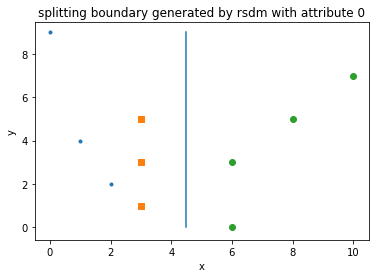

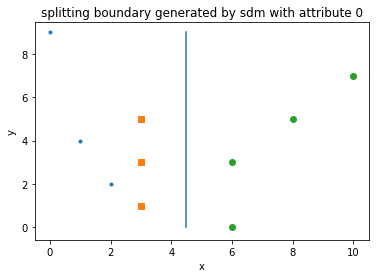

In [46]:
# rsdm 
f = Dsr()
g = Log()
h = Sum()

rsdm = Gdm(h, g, f)

# sdm
f = Ds()
g = Log()
h = Sum()

sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set, 0)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 0)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 0, "splitting boundary generated by rsdm with attribute 0")
display_discretization(training_set, threshold_nr, 0, "splitting boundary generated by sdm with attribute 0")

splitting value generated by rsdm on axis 1 :  4.5
corresponding entropy :  0.6088040034713086
splitting value generated by sdm on axis 1 :  8.0
corresponding entropy :  1.3774437510817343


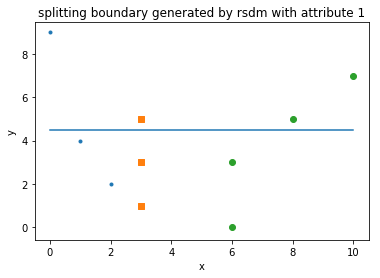

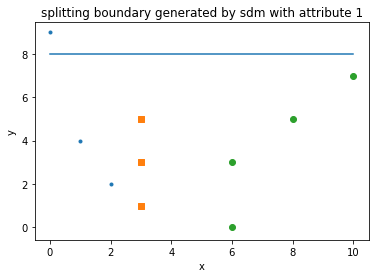

In [47]:
threshold_r, entropy_r = discretize(rsdm, training_set, 1)
print("splitting value generated by rsdm on axis 1 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 1)
print("splitting value generated by sdm on axis 1 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 1, "splitting boundary generated by rsdm with attribute 1")
display_discretization(training_set, threshold_nr, 1, "splitting boundary generated by sdm with attribute 1")

### Expérimentation sur des bases de données à deux dimensions

In [48]:
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
        return 2D dataset containing k classes and n examples, with a_j being the monotone attribute
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

In [49]:
f = Dsr()
rsdm = Gdm(h, g, f)

f = Ds()
sdm = Gdm(h, g, f)

### Rank Shannon discrimination measure et mesure d'entropie de Shannon

### 2 classes : 

#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  0.04415079636096053
splitting value generated by sdm on axis 0 :  0.04415079636096053


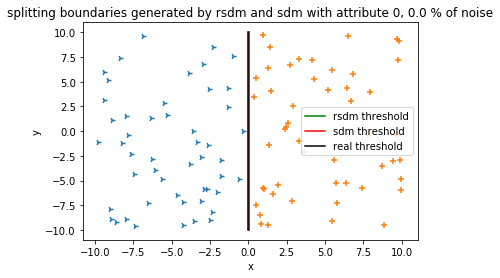

splitting value generated by rsdm on axis 0 :  0.31181910956723846
splitting value generated by sdm on axis 0 :  0.31181910956723846


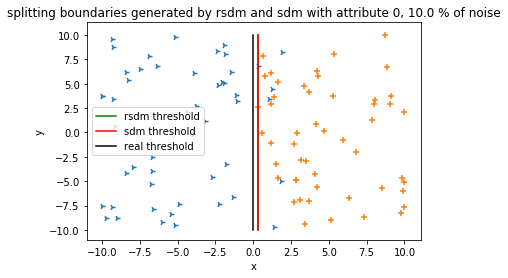

splitting value generated by rsdm on axis 0 :  1.5630310654757216
splitting value generated by sdm on axis 0 :  1.9896257653731884


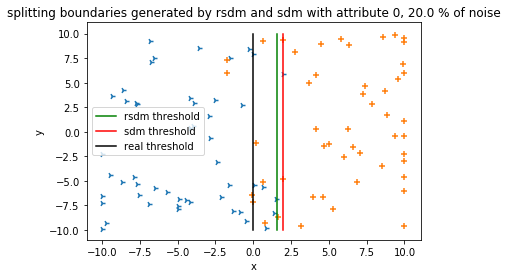

splitting value generated by rsdm on axis 0 :  1.5348447699166248
splitting value generated by sdm on axis 0 :  1.5348447699166248


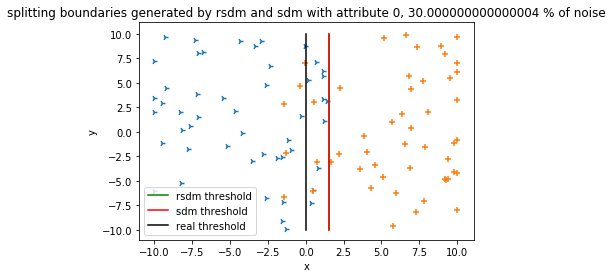

splitting value generated by rsdm on axis 0 :  -2.0293838541417597
splitting value generated by sdm on axis 0 :  -2.0293838541417597


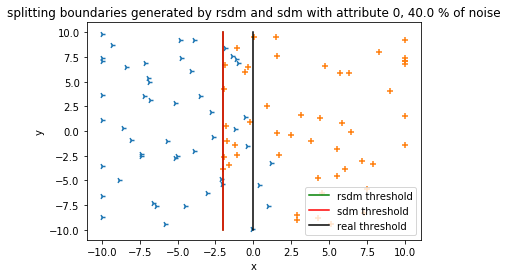

splitting value generated by rsdm on axis 0 :  -1.3391799207395778
splitting value generated by sdm on axis 0 :  -1.3391799207395778


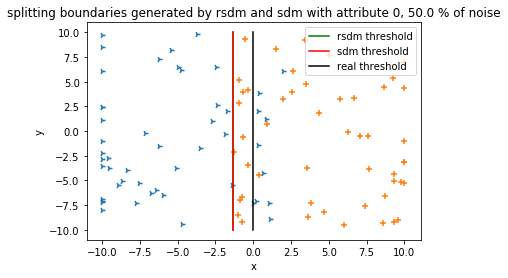

splitting value generated by rsdm on axis 0 :  1.3753907384779973
splitting value generated by sdm on axis 0 :  -1.8503095254364197


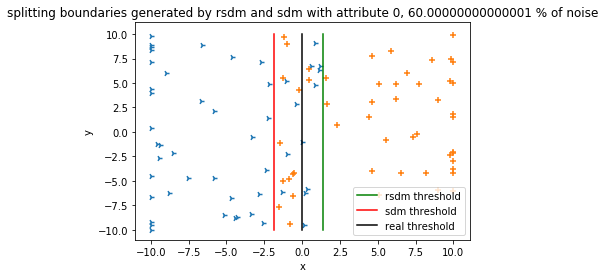

splitting value generated by rsdm on axis 0 :  -1.8484464220115195
splitting value generated by sdm on axis 0 :  -1.9627650558267882


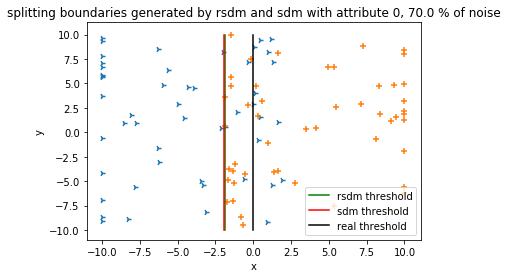

splitting value generated by rsdm on axis 0 :  1.9880395007252416
splitting value generated by sdm on axis 0 :  -2.0556222460701807


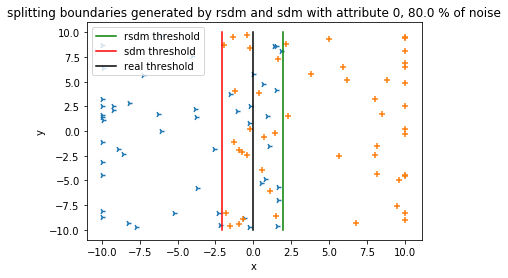

splitting value generated by rsdm on axis 0 :  1.9115277289891999
splitting value generated by sdm on axis 0 :  1.9115277289891999


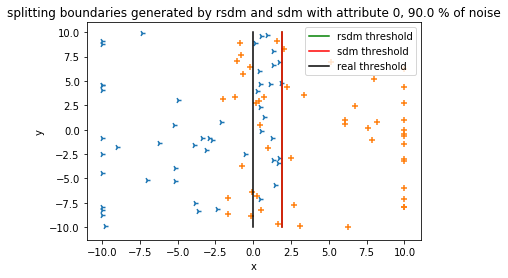

total run time : 103.86279702186584 s


In [92]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

threshold = 0

start = time.time()

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50)) # for displaying
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [threshold], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

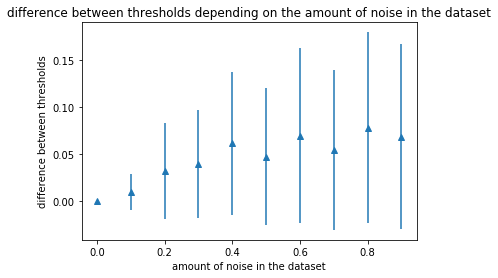

In [93]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20


x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [94]:
noises = np.arange(0., 0.5, 0.05)

threshold = 0

avg_diff_1 = []
avg_diff_2 = []
std_diff_1 = []
std_diff_2 = []

start = time.time()

for i in noises:
    threshold_diff1 = []
    threshold_diff2 = []

    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        threshold_diff1.append(fabs(threshold_r - threshold))

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        threshold_diff2.append(fabs(threshold_nr - threshold))
    
    avg_diff_1.append(np.average(threshold_diff1))
    std_diff_1.append(np.std(threshold_diff1))
    
    avg_diff_2.append(np.average(threshold_diff2))
    std_diff_2.append(np.std(threshold_diff2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 88.92425918579102 s


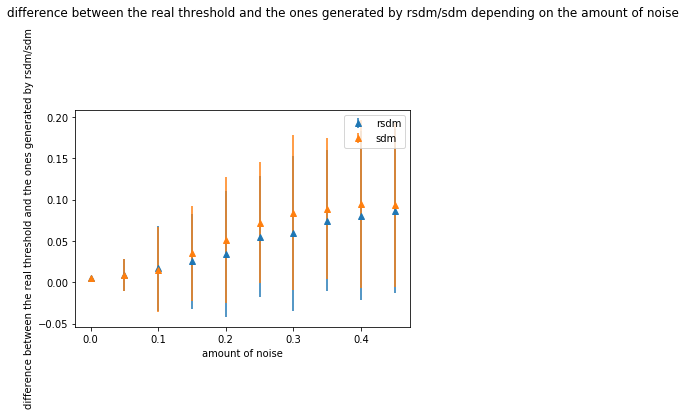

In [95]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

In [96]:
a_set, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

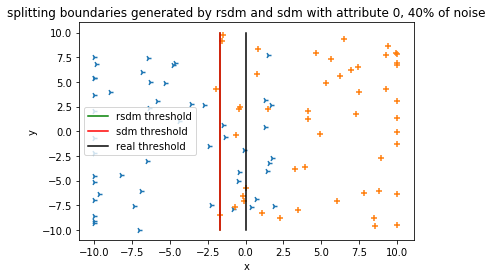

In [97]:
t1, h1 = discretize(rsdm, data_set, 0)
t2, h2 = discretize(sdm, data_set, 0)
display_discretizations_comparison(a_set, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

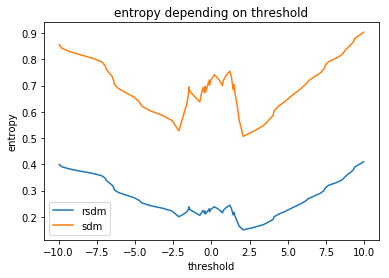

In [98]:
x, y1 = discretize_steps(rsdm, a_set, 0)
x, y2 = discretize_steps(sdm, a_set, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

#### Discrétisation de l'attribut non monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 1 :  -5.769026465217831
splitting value generated by sdm on axis 1 :  9.216673482379491


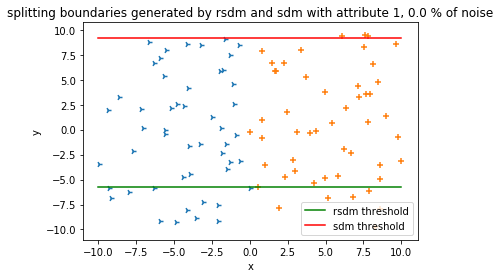

splitting value generated by rsdm on axis 1 :  2.840815228907953
splitting value generated by sdm on axis 1 :  -1.7301797187811667


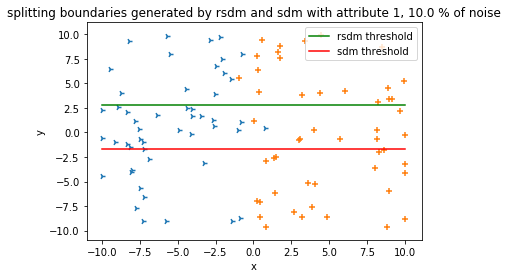

splitting value generated by rsdm on axis 1 :  8.677469160876859
splitting value generated by sdm on axis 1 :  2.9277090832130384


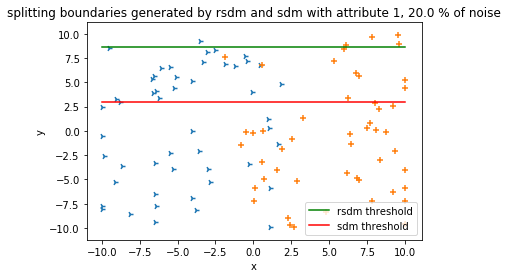

splitting value generated by rsdm on axis 1 :  7.24637366594281
splitting value generated by sdm on axis 1 :  9.778195772653302


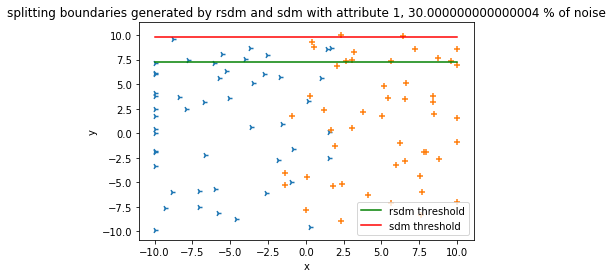

splitting value generated by rsdm on axis 1 :  -8.751945829458819
splitting value generated by sdm on axis 1 :  -8.751945829458819


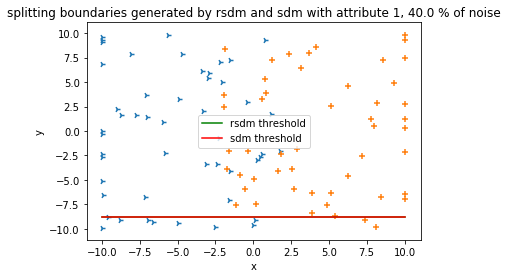

splitting value generated by rsdm on axis 1 :  9.813926703423705
splitting value generated by sdm on axis 1 :  -5.640686989908259


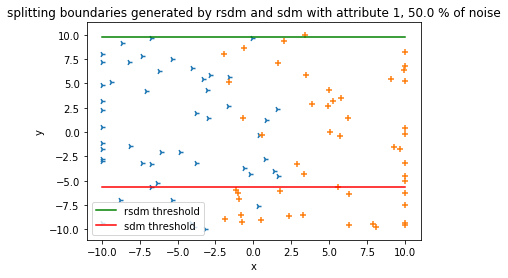

splitting value generated by rsdm on axis 1 :  -1.2559030154629491
splitting value generated by sdm on axis 1 :  -9.084306582213546


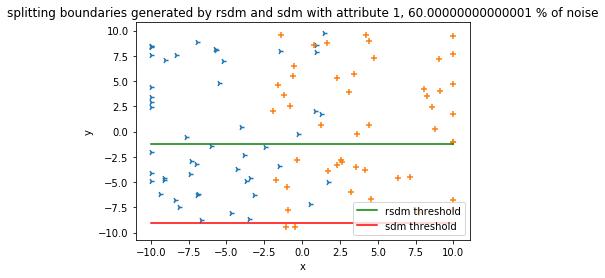

splitting value generated by rsdm on axis 1 :  1.7655462039872578
splitting value generated by sdm on axis 1 :  1.7655462039872578


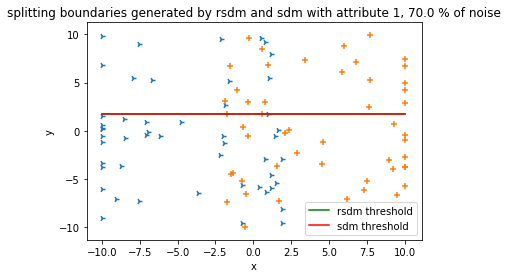

splitting value generated by rsdm on axis 1 :  -4.668922061891479
splitting value generated by sdm on axis 1 :  -8.607579709098422


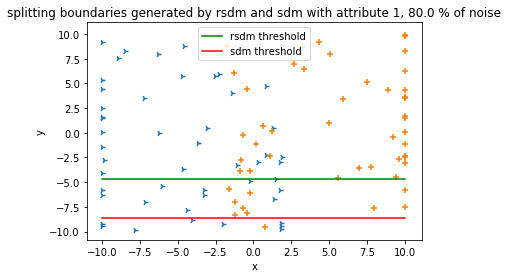

splitting value generated by rsdm on axis 1 :  8.036191375039474
splitting value generated by sdm on axis 1 :  -8.594299628770678


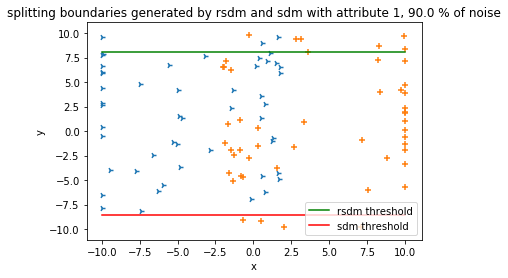

run time : -1528595827.3325012 s


In [99]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by sdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and sdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("run time : " + str(stop - start) + " s")

In [100]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

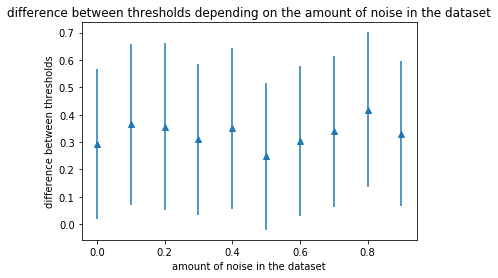

In [101]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

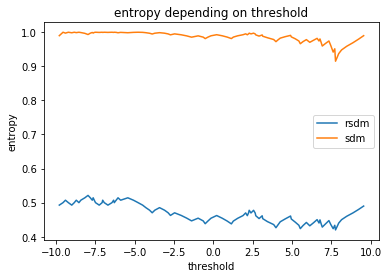

In [102]:
x, y1 = discretize_steps(rsdm, a_set, 1)
x, y2 = discretize_steps(sdm, a_set, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

### 3 classes

thresholds :  [(-10, -3.333333333333333), (-3.333333333333333, 3.333333333333334), (3.333333333333334, 10.0)]


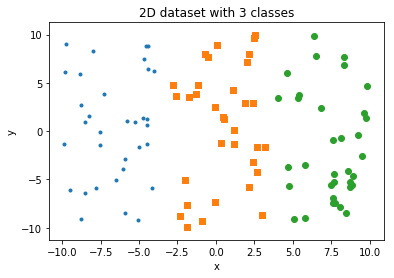

In [360]:
set3, t = generate_2Ddataset(0, 3, 100, 0, 0.1, [[-10, 10], [-10, 10]])
plot2DSet(set3, "2D dataset with 3 classes")
print("thresholds : ", t)

In [361]:
thr1 = t[0][1]
thr2 = t[2][0]

#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  3.3312342885685564
splitting value generated by sdm on axis 0 :  3.3312342885685564


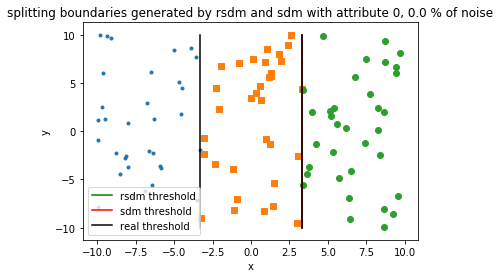

splitting value generated by rsdm on axis 0 :  3.396877568666099
splitting value generated by sdm on axis 0 :  3.396877568666099


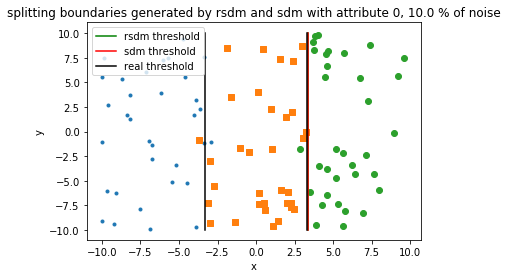

splitting value generated by rsdm on axis 0 :  1.9711157540412394
splitting value generated by sdm on axis 0 :  1.9711157540412394


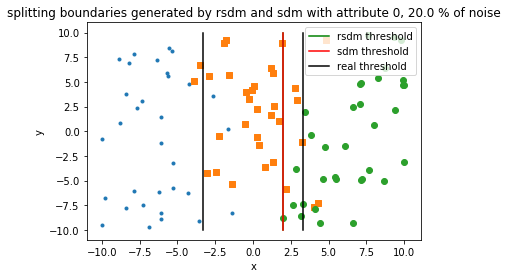

splitting value generated by rsdm on axis 0 :  1.438056378310916
splitting value generated by sdm on axis 0 :  1.438056378310916


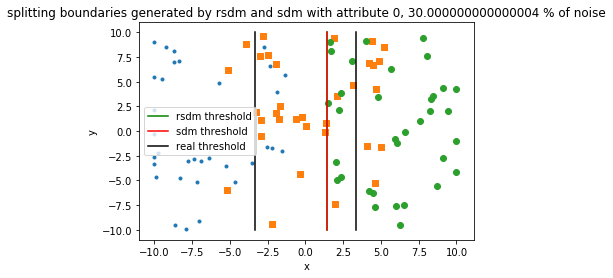

splitting value generated by rsdm on axis 0 :  2.129024867609359
splitting value generated by sdm on axis 0 :  2.129024867609359


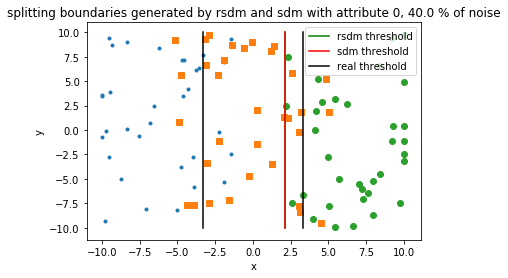

splitting value generated by rsdm on axis 0 :  1.4193067163056912
splitting value generated by sdm on axis 0 :  -1.0319945724938353


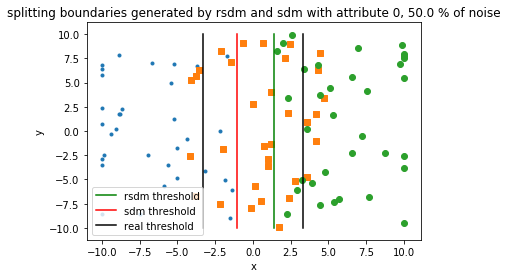

splitting value generated by rsdm on axis 0 :  1.129426707273609
splitting value generated by sdm on axis 0 :  -1.6678741328787916


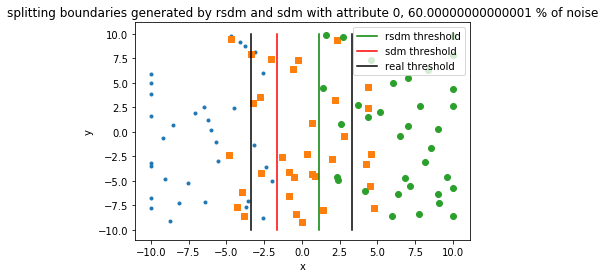

splitting value generated by rsdm on axis 0 :  1.4214154306862468
splitting value generated by sdm on axis 0 :  1.4214154306862468


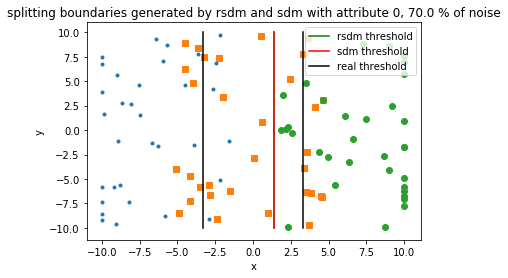

splitting value generated by rsdm on axis 0 :  1.0503808517756745
splitting value generated by sdm on axis 0 :  -0.809197721794537


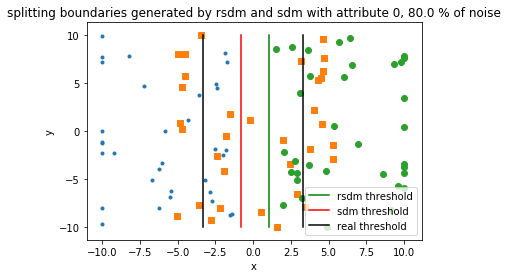

splitting value generated by rsdm on axis 0 :  1.4500942177279423
splitting value generated by sdm on axis 0 :  -1.8521115120817568


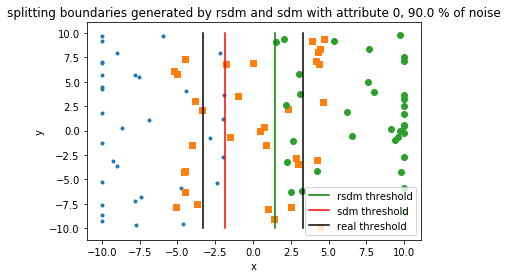

total run time : 126.12114644050598 s


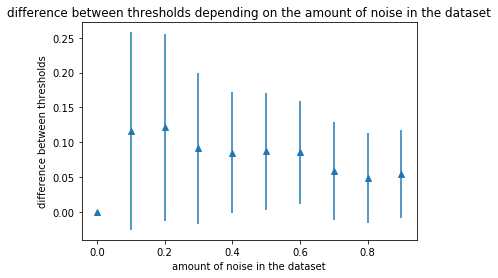

In [374]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [117]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and first threshold
avg_diff_1_1 = []
std_diff_1_1 = []

# difference between rsdm threshold and second threshold
avg_diff_1_2 = []
std_diff_1_2 = []

# difference between sdm threshold and first threshold
avg_diff_2_1 = []
std_diff_2_1 = []

# difference between sdm threshold and second threshold
avg_diff_2_2 = []
std_diff_2_2 = []

start = time.time()

for i in noises:
    threshold_diff1_1 = []
    threshold_diff1_2 = []
    threshold_diff2_1 = []
    threshold_diff2_2 = []
    
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        threshold_diff1_1.append(fabs(threshold_r - thr1))
        threshold_diff1_2.append(fabs(threshold_r - thr2))

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        
        threshold_diff2_1.append(fabs(threshold_nr - thr1))
        threshold_diff2_2.append(fabs(threshold_nr - thr2))
    
    avg_diff_1_1.append(np.average(threshold_diff1_1))
    avg_diff_1_2.append(np.average(threshold_diff1_2))
    std_diff_1_1.append(np.std(threshold_diff1_1))
    std_diff_1_2.append(np.std(threshold_diff1_2))
    
    avg_diff_2_1.append(np.average(threshold_diff2_1))
    avg_diff_2_2.append(np.average(threshold_diff2_2))
    std_diff_2_1.append(np.std(threshold_diff2_1))
    std_diff_2_2.append(np.std(threshold_diff2_2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 86.2765600681305 s


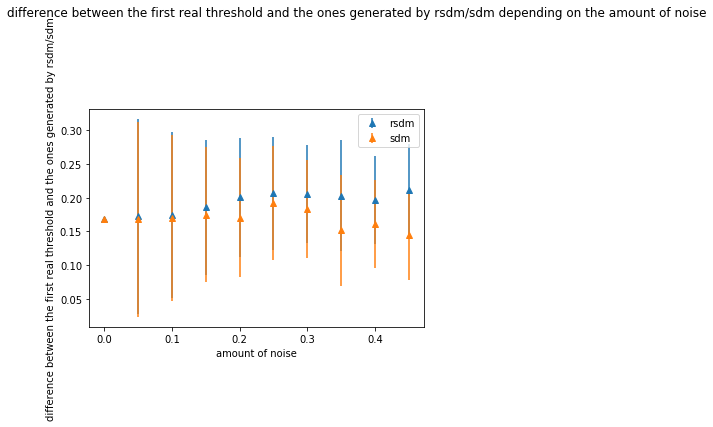

In [119]:
avg_diff_1_1_norm = np.array(avg_diff_1_1) / 20
std_diff_1_1_norm = np.array(std_diff_1_1) / 20

avg_diff_2_1_norm = np.array(avg_diff_2_1) / 20
std_diff_2_1_norm = np.array(std_diff_2_1) / 20

x1 = noises
y1 = avg_diff_1_1_norm
e1 = std_diff_1_1_norm

x2 = noises
y2 = avg_diff_2_1_norm
e2 = std_diff_2_1_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the first real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the first real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

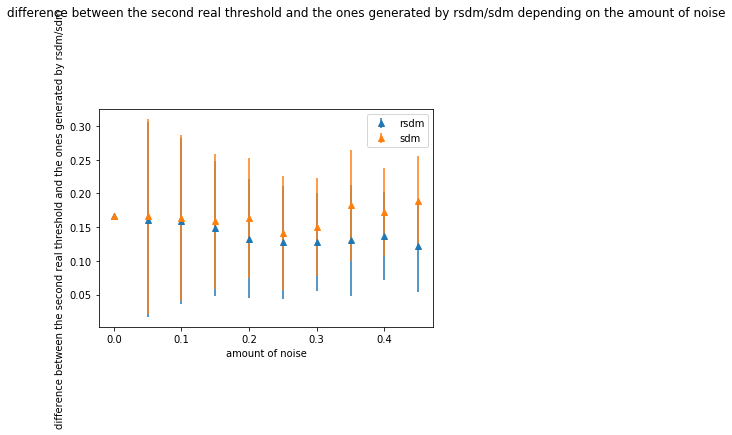

In [121]:
avg_diff_1_2_norm = np.array(avg_diff_1_2) / 20
std_diff_1_2_norm = np.array(std_diff_1_2) / 20

avg_diff_2_2_norm = np.array(avg_diff_2_2) / 20
std_diff_2_2_norm = np.array(std_diff_2_2) / 20

x1 = noises
y1 = avg_diff_1_2_norm
e1 = std_diff_1_2_norm

x2 = noises
y2 = avg_diff_2_2_norm
e2 = std_diff_2_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the second real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the second real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

In [364]:
set3, t = generate_2Ddataset(0, 3, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

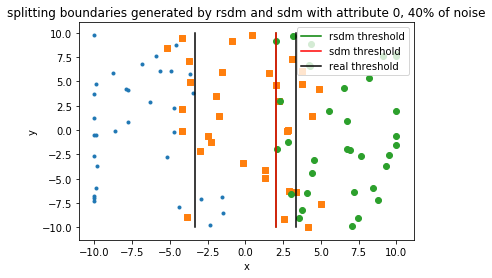

In [366]:
t1, h1 = discretize(rsdm, set3, 0)
t2, h2 = discretize(sdm, set3, 0)
display_discretizations_comparison(set3, t1, t2, [thr1, thr2], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

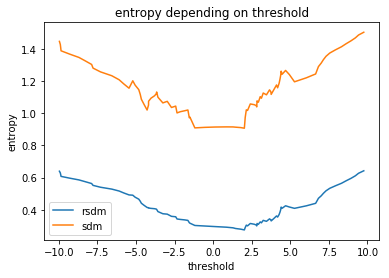

In [367]:
x, y1 = discretize_steps(rsdm, set3, 0)
x, y2 = discretize_steps(sdm, set3, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

#### Discrétisation de l'attribut non monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  8.63854616174427
splitting value generated by sdm on axis 0 :  8.63854616174427


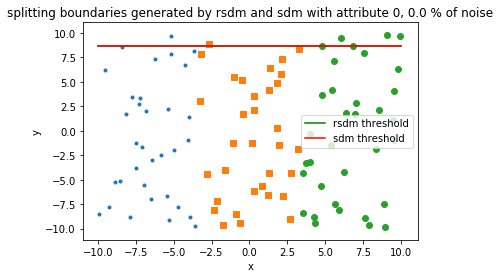

splitting value generated by rsdm on axis 0 :  9.273292848820041
splitting value generated by sdm on axis 0 :  -9.07771082117009


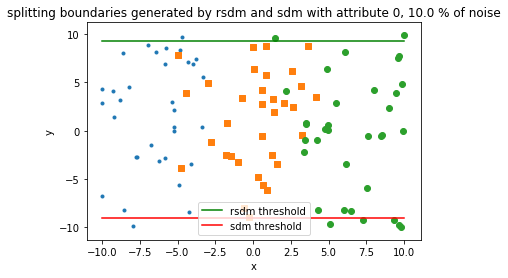

splitting value generated by rsdm on axis 0 :  -8.404186748498132
splitting value generated by sdm on axis 0 :  -8.404186748498132


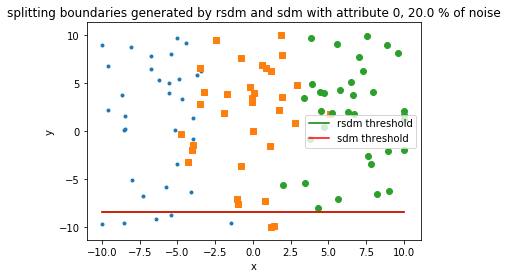

splitting value generated by rsdm on axis 0 :  -3.21669470924199
splitting value generated by sdm on axis 0 :  9.627876254313957


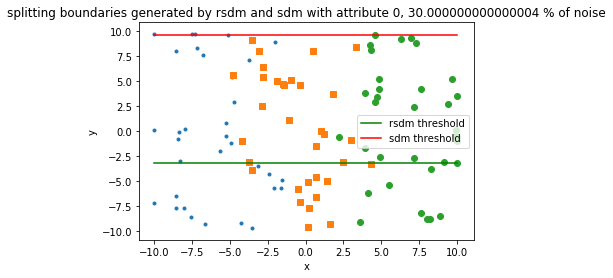

splitting value generated by rsdm on axis 0 :  -5.5759892100223905
splitting value generated by sdm on axis 0 :  6.887497577816278


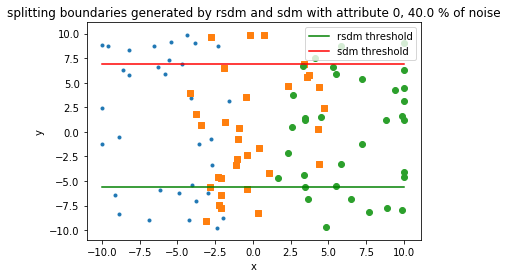

splitting value generated by rsdm on axis 0 :  9.493043940993676
splitting value generated by sdm on axis 0 :  -6.174523010948812


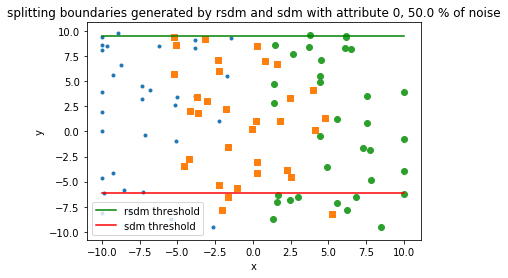

splitting value generated by rsdm on axis 0 :  -4.703349472884528
splitting value generated by sdm on axis 0 :  -8.275883453487882


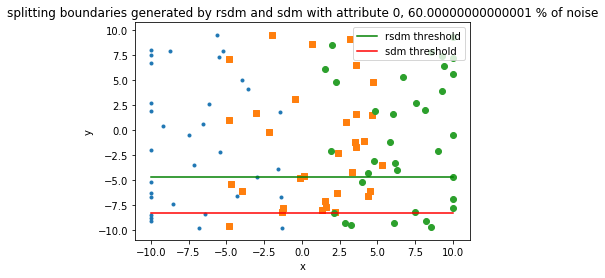

splitting value generated by rsdm on axis 0 :  8.184564652761743
splitting value generated by sdm on axis 0 :  -7.5852181285351765


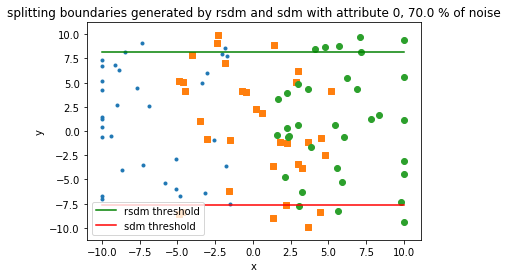

splitting value generated by rsdm on axis 0 :  -3.264981203454552
splitting value generated by sdm on axis 0 :  -2.067953949601221


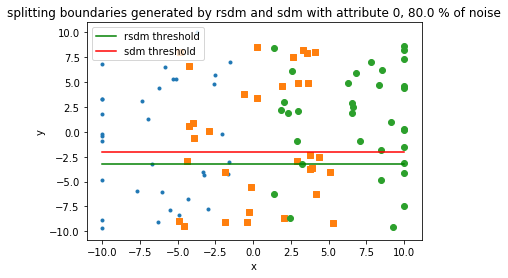

splitting value generated by rsdm on axis 0 :  6.163224592327218
splitting value generated by sdm on axis 0 :  9.277559033353006


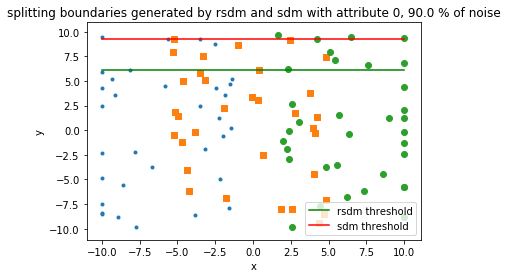

total run time : 434.9134724140167 s


In [363]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 3, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

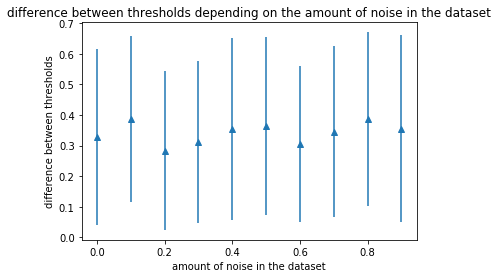

In [368]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

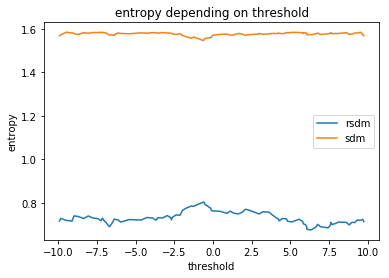

In [372]:
x, y1 = discretize_steps(rsdm, set3, 1)
x, y2 = discretize_steps(sdm, set3, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

### 4 classes

thresholds :  [(-10, -5.0), (-5.0, 0.0), (0.0, 5.0), (5.0, 10.0)]


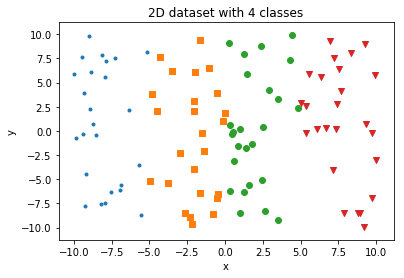

In [444]:
set4, t = generate_2Ddataset(0, 4, 100, 0, 0.1, [[-10, 10], [-10, 10]])
plot2DSet(set4, "2D dataset with 4 classes")
print("thresholds : ", t)

In [445]:
thr1 = t[0][1]
thr2 = t[1][1]
thr3 = t[2][1]
print(thr1, thr2, thr3)

-5.0 0.0 5.0


#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  -0.05206767000771034
splitting value generated by sdm on axis 0 :  -0.05206767000771034


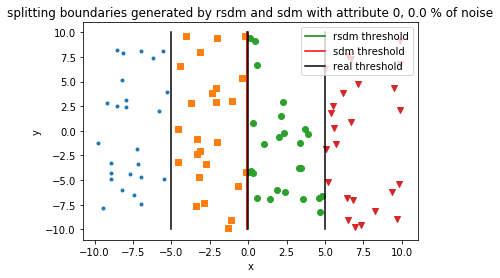

splitting value generated by rsdm on axis 0 :  1.8699906708605232
splitting value generated by sdm on axis 0 :  0.16958903593409191


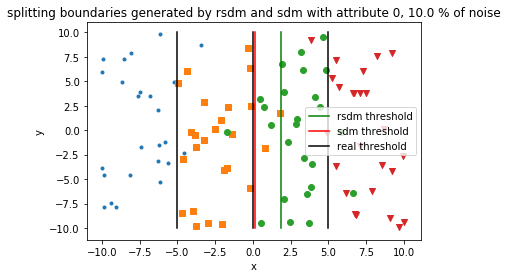

splitting value generated by rsdm on axis 0 :  0.544311379263508
splitting value generated by sdm on axis 0 :  0.544311379263508


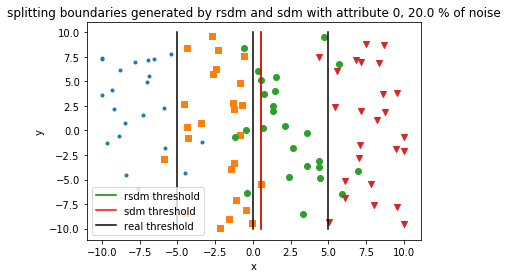

splitting value generated by rsdm on axis 0 :  1.653137439771833
splitting value generated by sdm on axis 0 :  0.3470874386608134


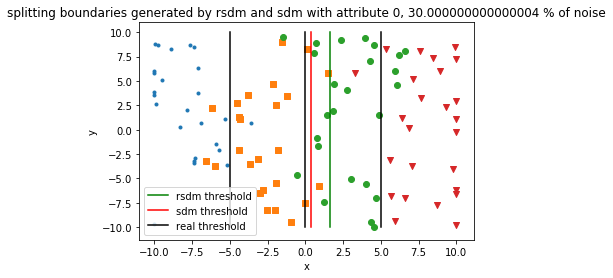

splitting value generated by rsdm on axis 0 :  3.449452606915746
splitting value generated by sdm on axis 0 :  -1.91799092525986


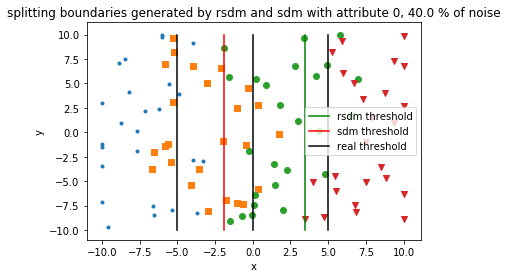

splitting value generated by rsdm on axis 0 :  1.2170272009553784
splitting value generated by sdm on axis 0 :  -2.154233276412172


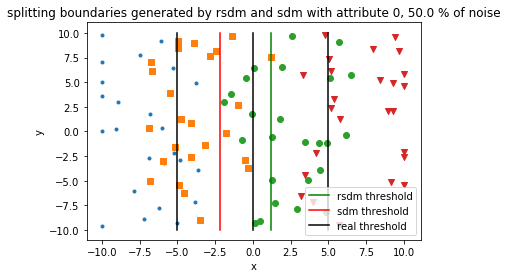

splitting value generated by rsdm on axis 0 :  3.30857298185137
splitting value generated by sdm on axis 0 :  -1.8491380204876737


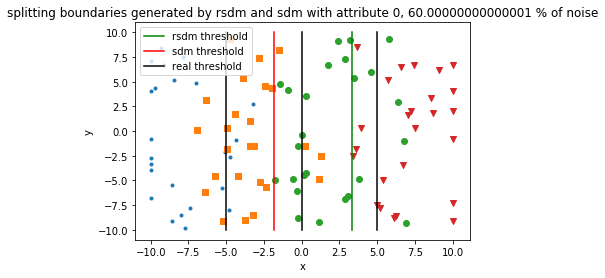

splitting value generated by rsdm on axis 0 :  2.579111800198201
splitting value generated by sdm on axis 0 :  -2.115814430813763


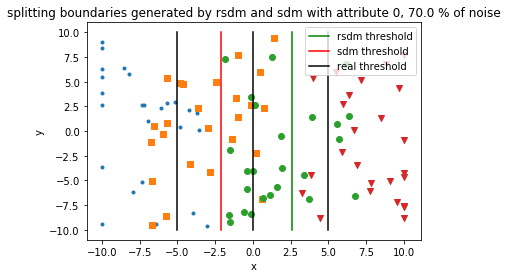

splitting value generated by rsdm on axis 0 :  3.1313839961645833
splitting value generated by sdm on axis 0 :  -2.241198647061064


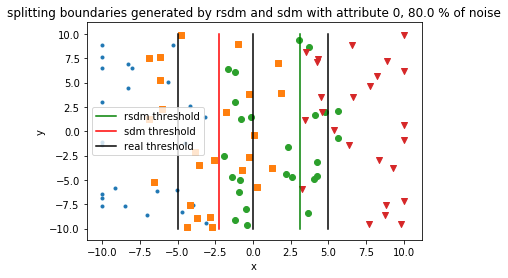

splitting value generated by rsdm on axis 0 :  2.024966490993367
splitting value generated by sdm on axis 0 :  2.024966490993367


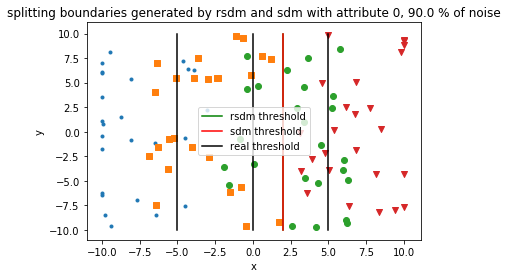

total run time : 174.66039562225342 s


In [422]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 4, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [thr1, thr2, thr3], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

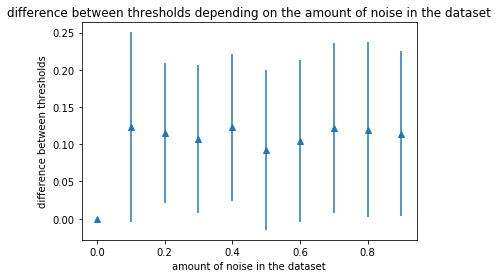

In [423]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [424]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and first threshold
avg_diff_1_1 = []
std_diff_1_1 = []

# difference between rsdm threshold and second threshold
avg_diff_1_2 = []
std_diff_1_2 = []

# difference between rsdm threshold and third threshold
avg_diff_1_3 = []
std_diff_1_3 = []


# difference between sdm threshold and first threshold
avg_diff_2_1 = []
std_diff_2_1 = []

# difference between sdm threshold and second threshold
avg_diff_2_2 = []
std_diff_2_2 = []

# difference between sdm threshold and third threshold
avg_diff_2_3 = []
std_diff_2_3 = []

start = time.time()

for i in noises:
    threshold_diff1_1 = []
    threshold_diff1_2 = []
    threshold_diff1_3 = []
    threshold_diff2_1 = []
    threshold_diff2_2 = []
    threshold_diff2_3 = []
    
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 4, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        threshold_diff1_1.append(fabs(threshold_r - thr1))
        threshold_diff1_2.append(fabs(threshold_r - thr2))
        threshold_diff1_3.append(fabs(threshold_r - thr3))
            
        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        
        threshold_diff2_1.append(fabs(threshold_nr - thr1))
        threshold_diff2_2.append(fabs(threshold_nr - thr2))
        threshold_diff2_3.append(fabs(threshold_nr - thr3))
        
    avg_diff_1_1.append(np.average(threshold_diff1_1))
    avg_diff_1_2.append(np.average(threshold_diff1_2))
    avg_diff_1_3.append(np.average(threshold_diff1_3))
    std_diff_1_1.append(np.std(threshold_diff1_1))
    std_diff_1_2.append(np.std(threshold_diff1_2))
    std_diff_1_3.append(np.std(threshold_diff1_3))
    
    avg_diff_2_1.append(np.average(threshold_diff2_1))
    avg_diff_2_2.append(np.average(threshold_diff2_2))
    avg_diff_2_3.append(np.average(threshold_diff2_3))
    std_diff_2_1.append(np.std(threshold_diff2_1))
    std_diff_2_2.append(np.std(threshold_diff2_2))
    std_diff_2_3.append(np.std(threshold_diff2_3))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 130.69751358032227 s


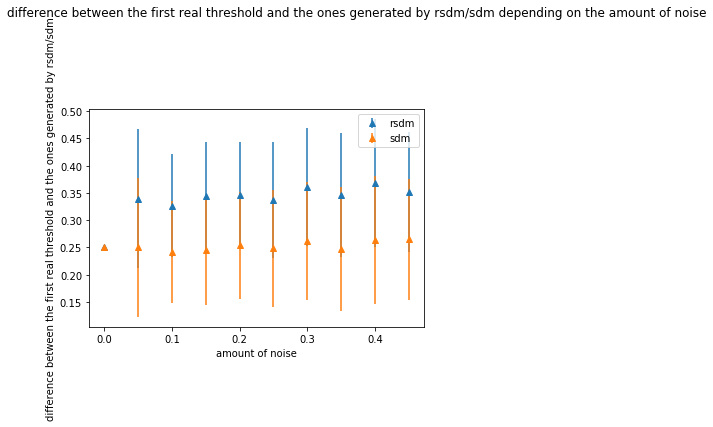

In [425]:
avg_diff_1_1_norm = np.array(avg_diff_1_1) / 20
std_diff_1_1_norm = np.array(std_diff_1_1) / 20

avg_diff_2_1_norm = np.array(avg_diff_2_1) / 20
std_diff_2_1_norm = np.array(std_diff_2_1) / 20

x1 = noises
y1 = avg_diff_1_1_norm
e1 = std_diff_1_1_norm

x2 = noises
y2 = avg_diff_2_1_norm
e2 = std_diff_2_1_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the first real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the first real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

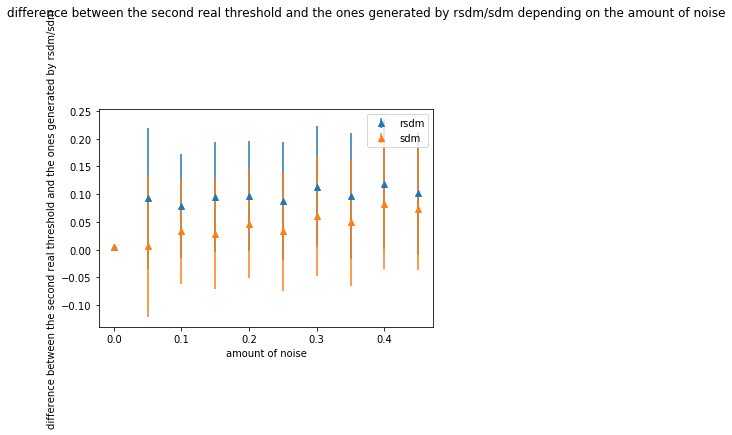

In [426]:
avg_diff_1_2_norm = np.array(avg_diff_1_2) / 20
std_diff_1_2_norm = np.array(std_diff_1_2) / 20

avg_diff_2_2_norm = np.array(avg_diff_2_2) / 20
std_diff_2_2_norm = np.array(std_diff_2_2) / 20

x1 = noises
y1 = avg_diff_1_2_norm
e1 = std_diff_1_2_norm

x2 = noises
y2 = avg_diff_2_2_norm
e2 = std_diff_2_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the second real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the second real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

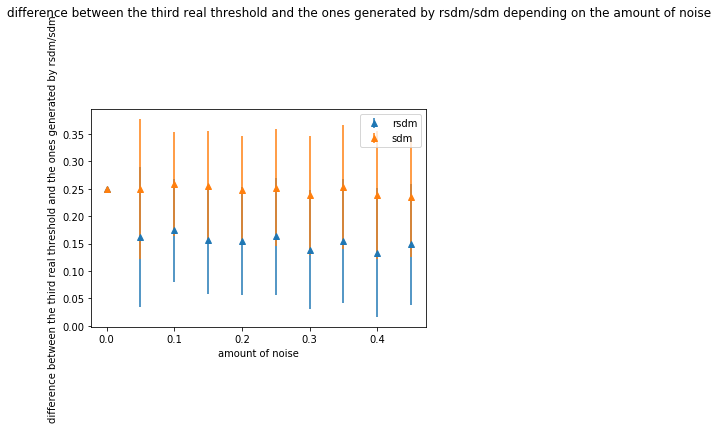

In [428]:
avg_diff_1_3_norm = np.array(avg_diff_1_3) / 20
std_diff_1_3_norm = np.array(std_diff_1_3) / 20

avg_diff_2_3_norm = np.array(avg_diff_2_3) / 20
std_diff_2_3_norm = np.array(std_diff_2_3) / 20

x1 = noises
y1 = avg_diff_1_3_norm
e1 = std_diff_1_3_norm

x2 = noises
y2 = avg_diff_2_3_norm
e2 = std_diff_2_3_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the third real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the third real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

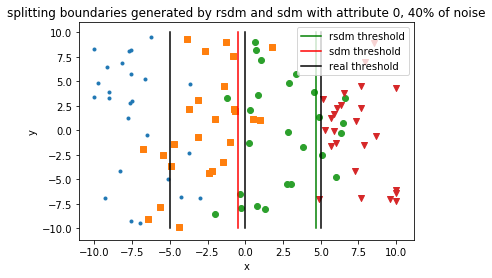

In [446]:
set4, t = generate_2Ddataset(0, 4, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set4, 0)
t2, h2 = discretize(sdm, set4, 0)
display_discretizations_comparison(set4, t1, t2, [thr1, thr2, thr3], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

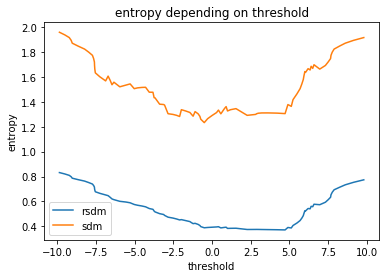

In [447]:
x, y1 = discretize_steps(rsdm, set4, 0)
x, y2 = discretize_steps(sdm, set4, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

### 6 classes

thresholds :  [(-10, -6.666666666666666), (-6.666666666666666, -3.3333333333333326), (-3.3333333333333326, 8.881784197001252e-16), (8.881784197001252e-16, 3.3333333333333344), (3.3333333333333344, 6.666666666666668), (6.666666666666668, 10)]


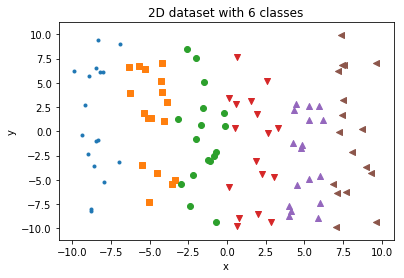

In [433]:
set6, t = generate_2Ddataset(0, 6, 100, 0, 0.1, [[-10, 10], [-10, 10]])
plot2DSet(set6, "2D dataset with 6 classes")
print("thresholds : ", t)

In [435]:
thr1 = t[0][1]
thr2 = t[1][1]
thr3 = t[2][1]
thr4 = t[3][1]
thr5 = t[4][1]
thr = [thr1, thr2, thr3, thr4, thr5]
print(thr)

[-6.666666666666666, -3.3333333333333326, 8.881784197001252e-16, 3.3333333333333344, 6.666666666666668]


#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  3.3074609985593204
splitting value generated by sdm on axis 0 :  0.08919081479908741


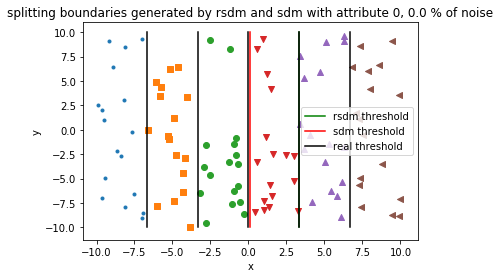

splitting value generated by rsdm on axis 0 :  3.342361490196907
splitting value generated by sdm on axis 0 :  -3.326678131892929


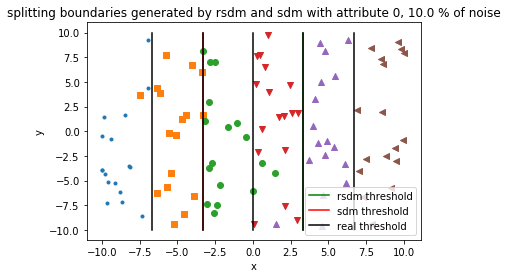

splitting value generated by rsdm on axis 0 :  1.5105478064277298
splitting value generated by sdm on axis 0 :  0.01226506185703654


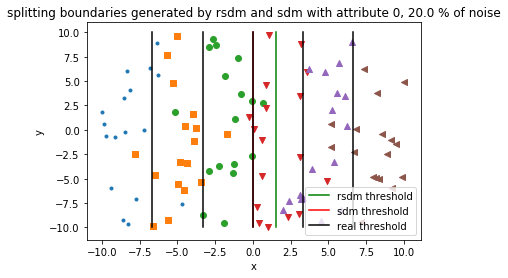

splitting value generated by rsdm on axis 0 :  3.5332448348647336
splitting value generated by sdm on axis 0 :  0.06620716968595242


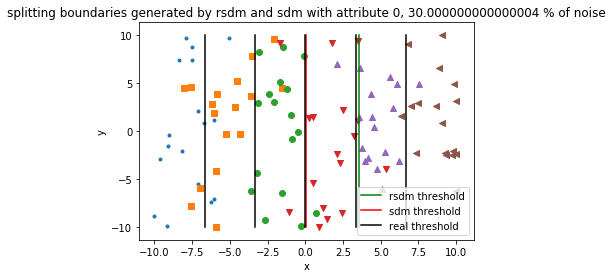

splitting value generated by rsdm on axis 0 :  2.317950123751925
splitting value generated by sdm on axis 0 :  1.9564471031680788


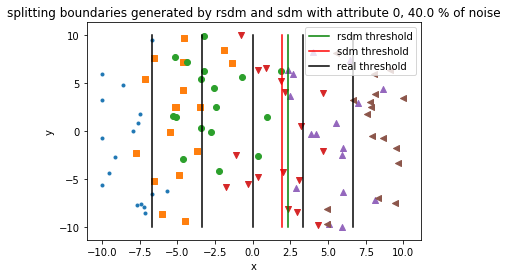

splitting value generated by rsdm on axis 0 :  1.3016526080751434
splitting value generated by sdm on axis 0 :  -1.7474145819547378


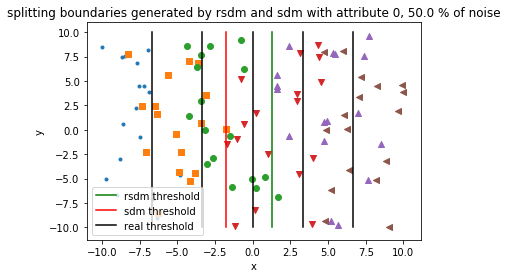

splitting value generated by rsdm on axis 0 :  2.5416907503900745
splitting value generated by sdm on axis 0 :  -0.8287776566653067


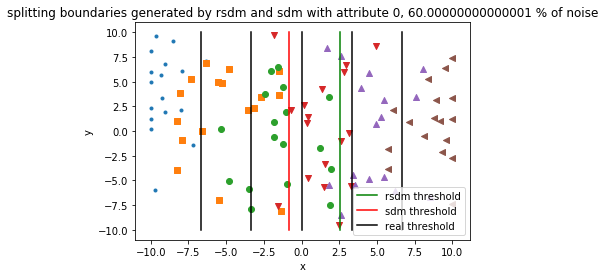

splitting value generated by rsdm on axis 0 :  1.2965485092898166
splitting value generated by sdm on axis 0 :  -1.6909280420005564


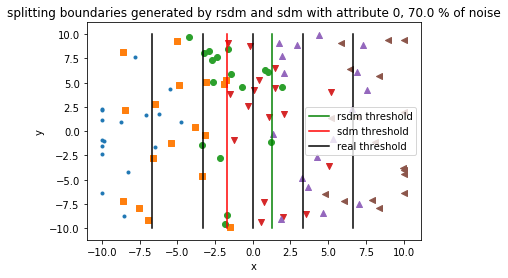

splitting value generated by rsdm on axis 0 :  1.8429663637895204
splitting value generated by sdm on axis 0 :  -0.7525847929992276


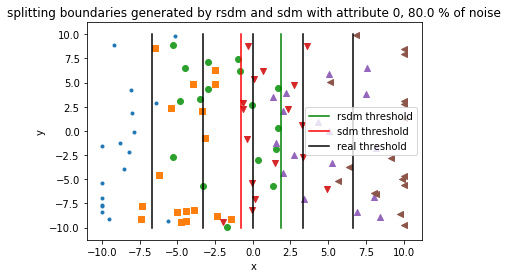

splitting value generated by rsdm on axis 0 :  1.6797699816274319
splitting value generated by sdm on axis 0 :  1.6797699816274319


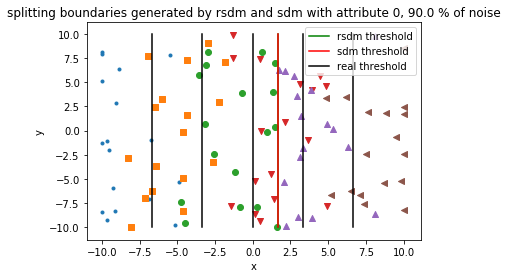

total run time : 210.74441027641296 s


In [436]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 6, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, thr, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

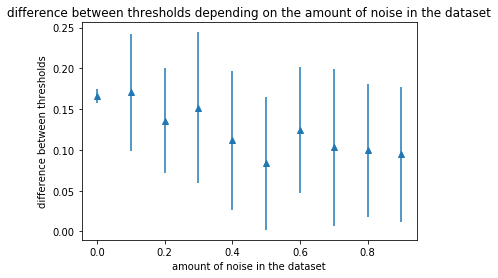

In [437]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [439]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and closest real threshold
avg_diff_1 = []
std_diff_1 = []

# difference between sdm threshold and closest real threshold
avg_diff_2 = []
std_diff_2 = []


start = time.time()

for i in noises:
    threshold_diff_1 = []
    threshold_diff_2 = []
    
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 6, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        diff = [fabs(threshold_r - thr1), fabs(threshold_r - thr2), fabs(threshold_r - thr3), fabs(threshold_r - thr4), fabs(threshold_r - thr5)]
        threshold_diff_1.append(min(diff))
            
        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        
        diff = [fabs(threshold_nr - thr1), fabs(threshold_nr - thr2), fabs(threshold_nr - thr3), fabs(threshold_nr - thr4), fabs(threshold_nr - thr5)]
        threshold_diff_2.append(min(diff))
        
    avg_diff_1.append(np.average(threshold_diff_1))
    std_diff_1.append(np.std(threshold_diff_1))

    avg_diff_2.append(np.average(threshold_diff_2))
    std_diff_2.append(np.std(threshold_diff_2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 154.5233588218689 s


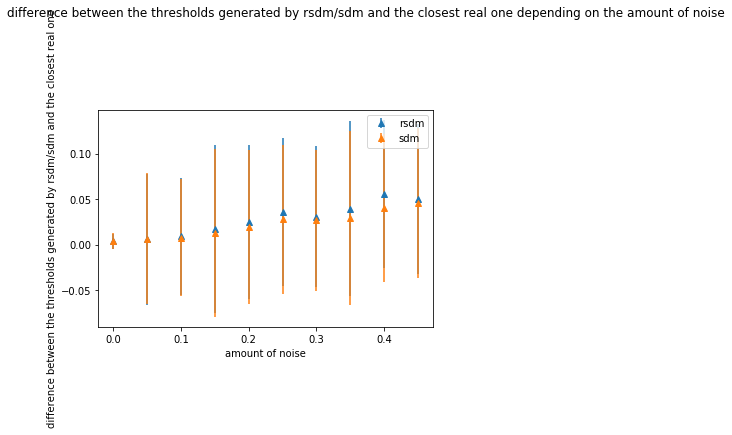

In [440]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the thresholds generated by rsdm/sdm and the closest real one")
plt.title("difference between the thresholds generated by rsdm/sdm and the closest real one depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

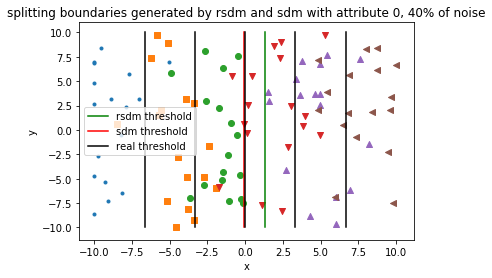

In [441]:
set6, t = generate_2Ddataset(0, 6, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set6, 0)
t2, h2 = discretize(sdm, set6, 0)
display_discretizations_comparison(set6, t1, t2, thr, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

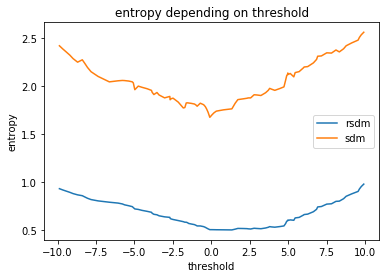

In [442]:
x, y1 = discretize_steps(rsdm, set6, 0)
x, y2 = discretize_steps(sdm, set6, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

## Rank Shannon discrimination measure et rank Gini discrimination measure

In [450]:
f_layer = Dsr()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

### 2 classes

In [52]:
thr = [0]

#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  0.011550644284961664
splitting value generated by rgdm on axis 0 :  0.011550644284961664


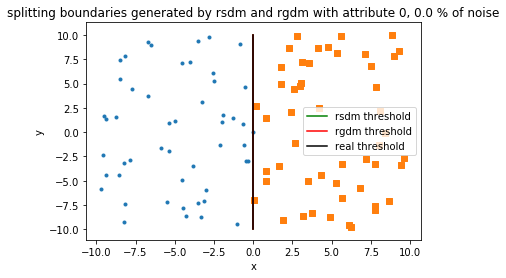

splitting value generated by rsdm on axis 0 :  0.0017793619716469644
splitting value generated by rgdm on axis 0 :  0.0017793619716469644


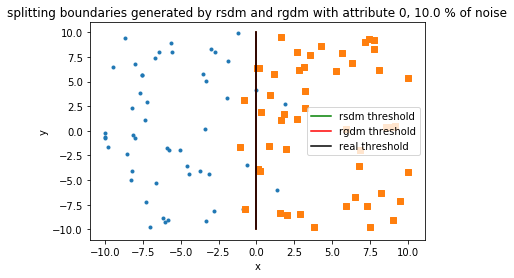

splitting value generated by rsdm on axis 0 :  0.6853987459734153
splitting value generated by rgdm on axis 0 :  0.6853987459734153


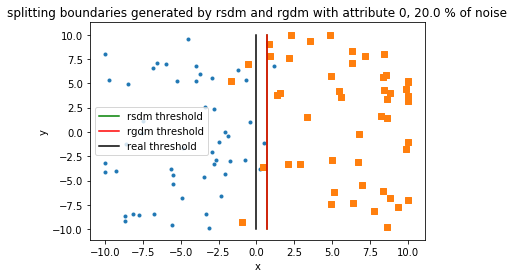

splitting value generated by rsdm on axis 0 :  0.7096884474248557
splitting value generated by rgdm on axis 0 :  0.7096884474248557


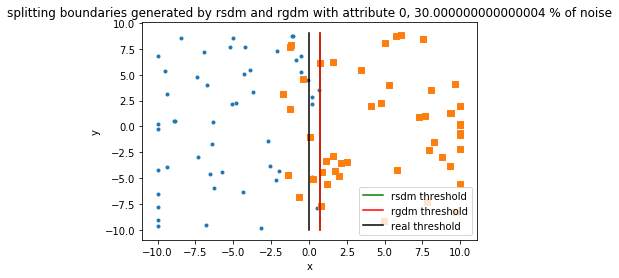

splitting value generated by rsdm on axis 0 :  -1.6535430767875006
splitting value generated by rgdm on axis 0 :  -1.6535430767875006


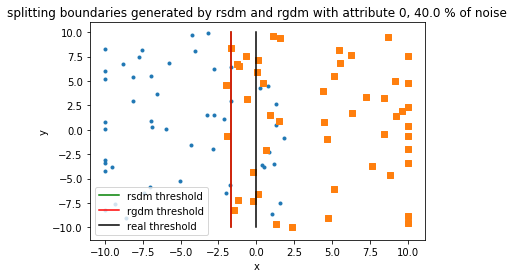

splitting value generated by rsdm on axis 0 :  -1.8618544636160408
splitting value generated by rgdm on axis 0 :  -1.3397982988405066


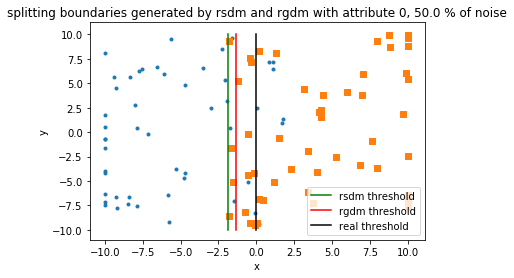

splitting value generated by rsdm on axis 0 :  -2.219225336677783
splitting value generated by rgdm on axis 0 :  1.8173732147145274


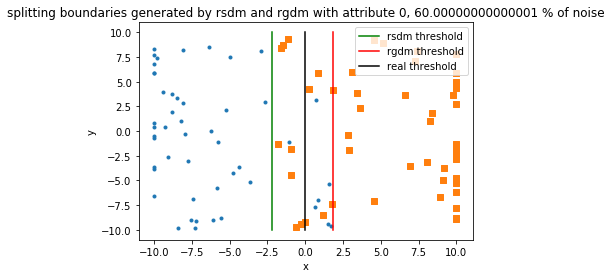

splitting value generated by rsdm on axis 0 :  1.9483991164817223
splitting value generated by rgdm on axis 0 :  1.9483991164817223


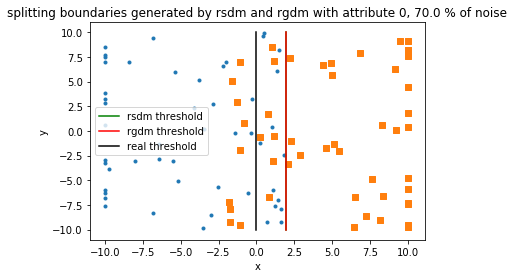

splitting value generated by rsdm on axis 0 :  2.2026427037240413
splitting value generated by rgdm on axis 0 :  2.2026427037240413


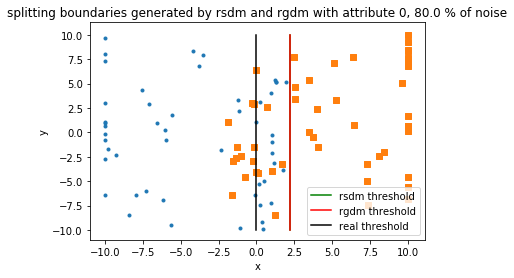

splitting value generated by rsdm on axis 0 :  1.9590371094218622
splitting value generated by rgdm on axis 0 :  1.9590371094218622


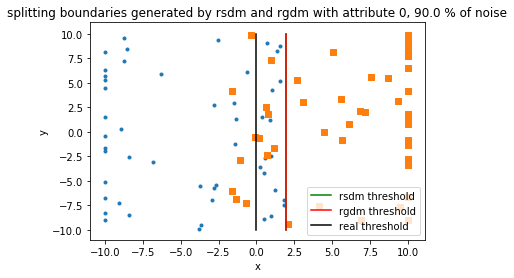

total run time : 129.31896829605103 s


In [453]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(rgdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by rgdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, thr, 0, "splitting boundaries generated by rsdm and rgdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "rgdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

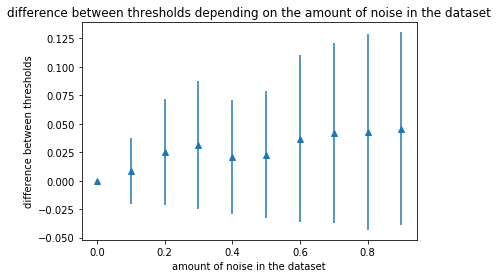

In [454]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [80]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and real threshold
avg_diff_1 = []
std_diff_1 = []

# difference between rgdm threshold and real threshold
avg_diff_2 = []
std_diff_2 = []


start = time.time()

for i in noises:
    threshold_diff_1 = []
    threshold_diff_2 = []
    
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 6, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        threshold_diff_1.append(fabs(threshold_r - 0))
            
        threshold_nr, entropy_nr = discretize(rgdm, data_set, 0)
        
        threshold_diff_2.append(fabs(threshold_nr - 0))
        
    avg_diff_1.append(np.average(threshold_diff_1))
    std_diff_1.append(np.std(threshold_diff_1))

    avg_diff_2.append(np.average(threshold_diff_2))
    std_diff_2.append(np.std(threshold_diff_2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 329.59360218048096 s


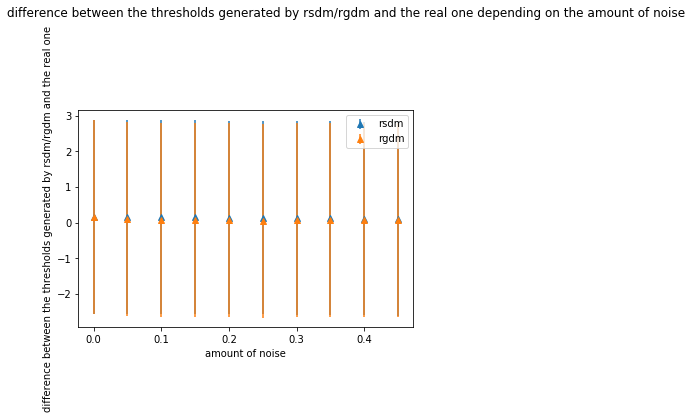

In [81]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='rgdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the thresholds generated by rsdm/rgdm and the real one")
plt.title("difference between the thresholds generated by rsdm/rgdm and the real one depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

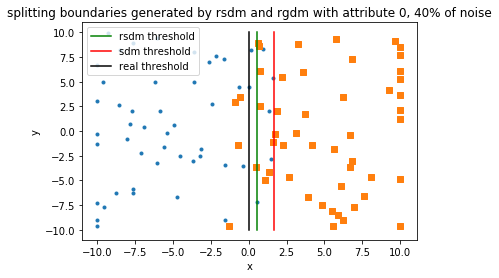

In [458]:
set2, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set2, 0)
t2, h2 = discretize(rgdm, set2, 0)
display_discretizations_comparison(set2, t1, t2, thr, 0, "splitting boundaries generated by rsdm and rgdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

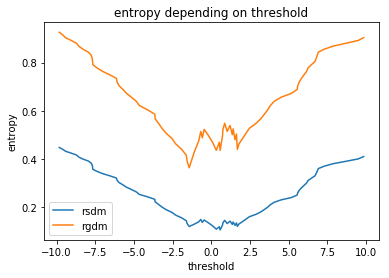

In [459]:
x, y1 = discretize_steps(rsdm, set2, 0)
x, y2 = discretize_steps(sdm, set2, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="rgdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

#### Discrétisation de l'attribut non monotone

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 1 :  4.193032737708794
splitting value generated by rgdm on axis 1 :  4.193032737708794


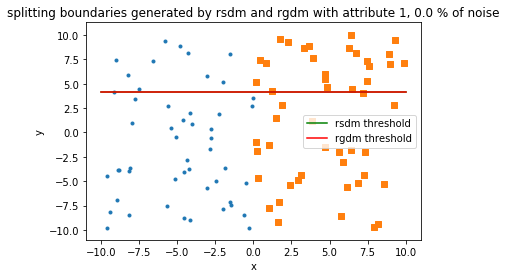

splitting value generated by rsdm on axis 1 :  4.481890543737294
splitting value generated by rgdm on axis 1 :  4.481890543737294


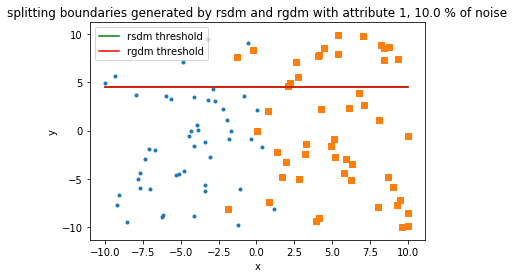

splitting value generated by rsdm on axis 1 :  3.7729334356609527
splitting value generated by rgdm on axis 1 :  8.096940673713313


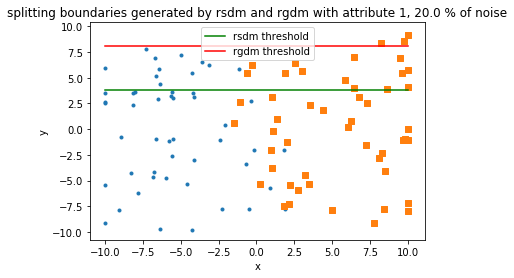

splitting value generated by rsdm on axis 1 :  4.866530579645909
splitting value generated by rgdm on axis 1 :  4.866530579645909


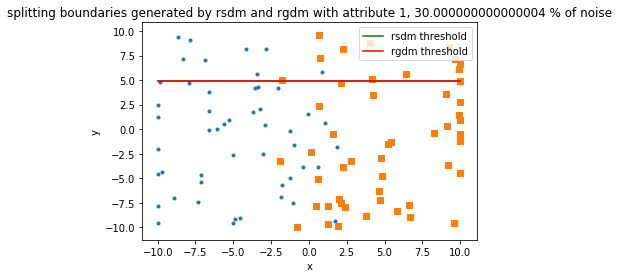

splitting value generated by rsdm on axis 1 :  7.109574458100774
splitting value generated by rgdm on axis 1 :  7.109574458100774


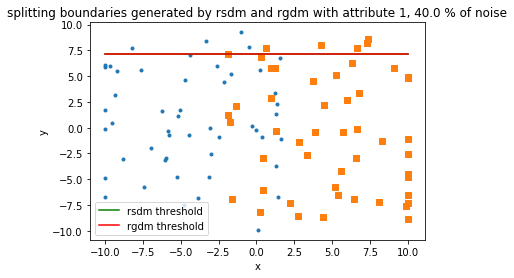

splitting value generated by rsdm on axis 1 :  2.8664875707690882
splitting value generated by rgdm on axis 1 :  2.8664875707690882


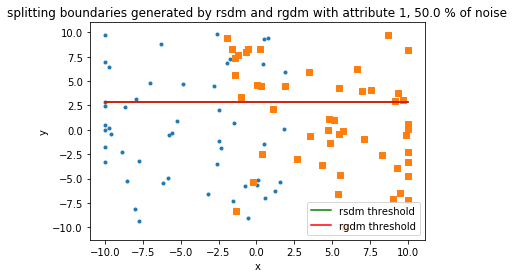

splitting value generated by rsdm on axis 1 :  -1.5178456383749248
splitting value generated by rgdm on axis 1 :  -1.5178456383749248


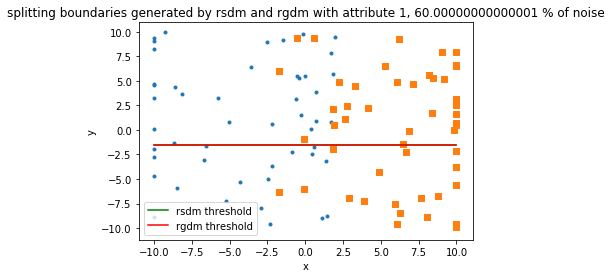

splitting value generated by rsdm on axis 1 :  3.6064897600969203
splitting value generated by rgdm on axis 1 :  3.6064897600969203


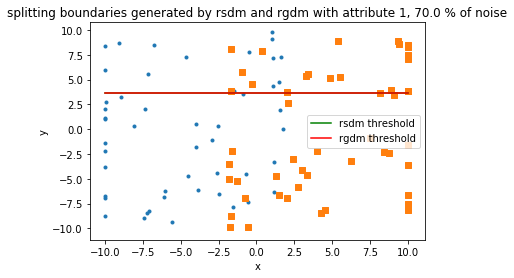

splitting value generated by rsdm on axis 1 :  -1.4617090448325136
splitting value generated by rgdm on axis 1 :  -1.4617090448325136


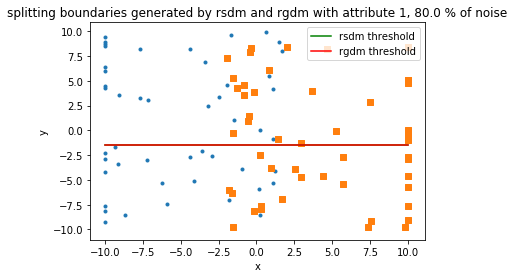

splitting value generated by rsdm on axis 1 :  -9.709196907009874
splitting value generated by rgdm on axis 1 :  -9.709196907009874


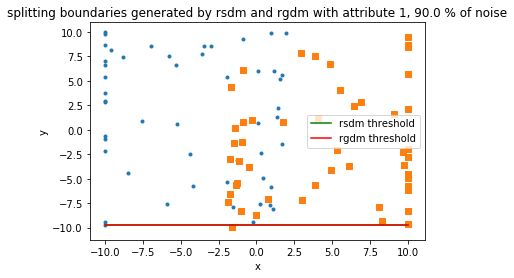

total run time : 577.4522140026093 s


In [467]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(rgdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by rgdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and rgdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "rgdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

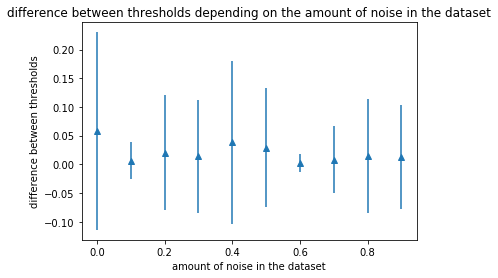

In [463]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

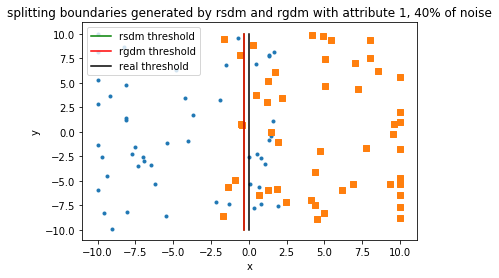

In [464]:
set2, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set2, 1)
t2, h2 = discretize(rgdm, set2, 1)
display_discretizations_comparison(set2, t1, t2, thr, 0, "splitting boundaries generated by rsdm and rgdm with attribute 1, 40% of noise", "rsdm threshold", "rgdm threshold")

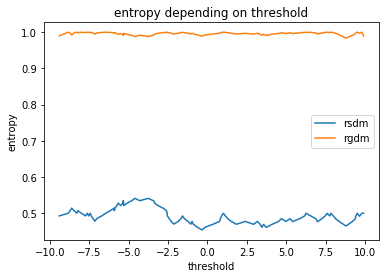

In [465]:
x, y1 = discretize_steps(rsdm, set2, 1)
x, y2 = discretize_steps(sdm, set2, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="rgdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

## Rank Shannon discrimination measure et pessimistic rank discrimination measure

In [50]:
f_layer_shannon = Dsr()
f_layer_pess = Mindsr()

g_layer_shannon = Log()
g_layer_pess = Frac()
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer_shannon)
prdm = Gdm(h_layer, g_layer_pess, f_layer_pess)

splitting value generated by rsdm on axis 0 :  -0.02948849421267563
splitting value generated by prdm on axis 0 :  -0.02948849421267563


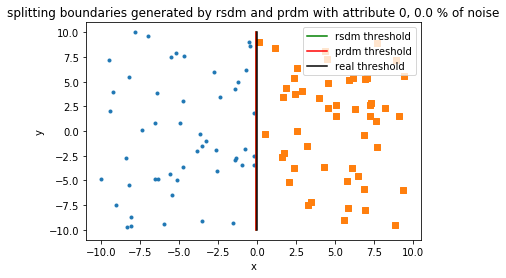

splitting value generated by rsdm on axis 0 :  0.09486495566467135
splitting value generated by prdm on axis 0 :  -0.5321864755276521


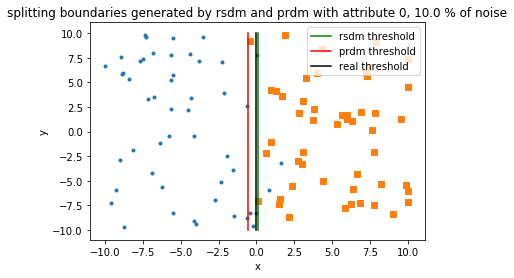

splitting value generated by rsdm on axis 0 :  1.4486545225319252
splitting value generated by prdm on axis 0 :  -2.1708571965483117


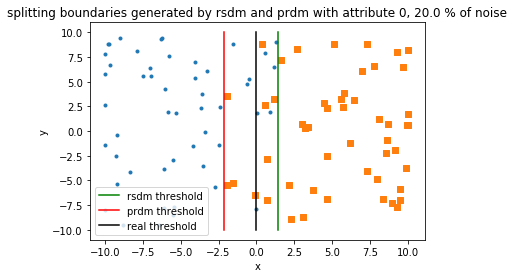

splitting value generated by rsdm on axis 0 :  -1.3587744333363234
splitting value generated by prdm on axis 0 :  -1.950596470170654


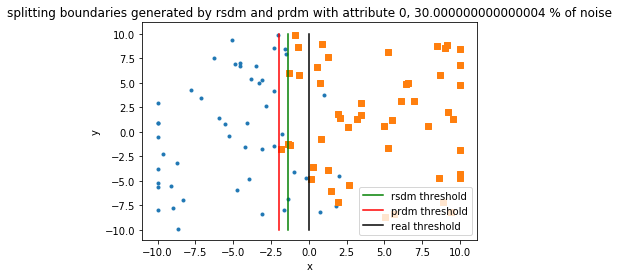

splitting value generated by rsdm on axis 0 :  1.433767757087645
splitting value generated by prdm on axis 0 :  -2.3068037672580366


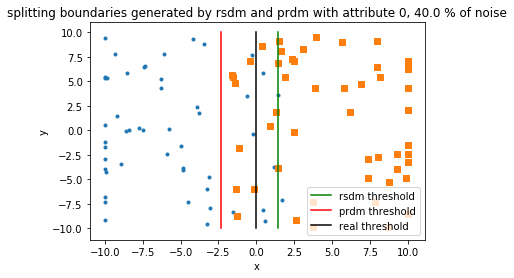

splitting value generated by rsdm on axis 0 :  -0.16115807848596253
splitting value generated by prdm on axis 0 :  -2.209551253733488


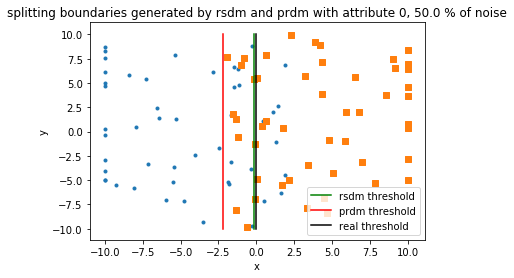

splitting value generated by rsdm on axis 0 :  1.8180659962883083
splitting value generated by prdm on axis 0 :  -2.028338619941462


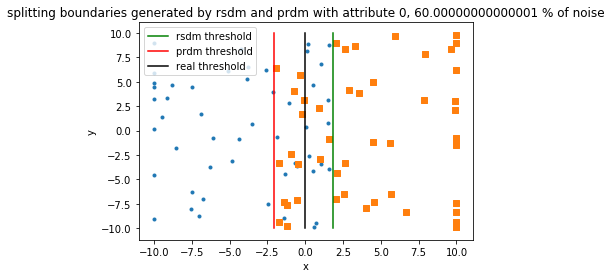

splitting value generated by rsdm on axis 0 :  -2.0503811074782368
splitting value generated by prdm on axis 0 :  -2.0503811074782368


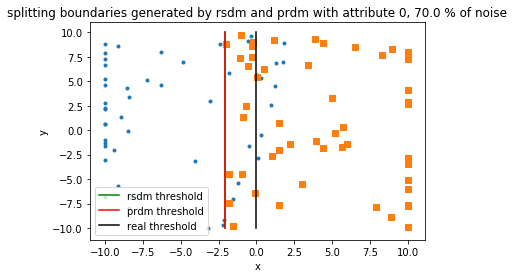

splitting value generated by rsdm on axis 0 :  2.3170715851327377
splitting value generated by prdm on axis 0 :  -1.857070466082578


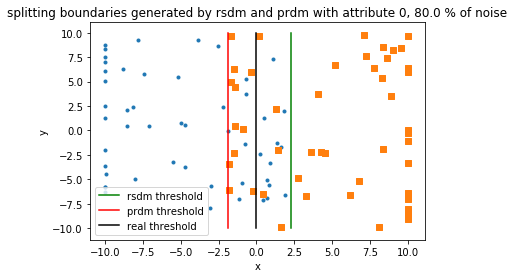

splitting value generated by rsdm on axis 0 :  -2.2824658631817223
splitting value generated by prdm on axis 0 :  -2.2824658631817223


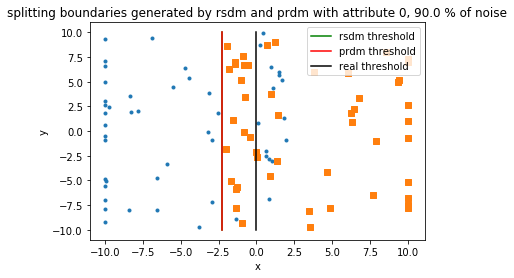

total run time : 1300.050270318985 s


In [596]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(prdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by prdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, thr, 0, "splitting boundaries generated by rsdm and prdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "prdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

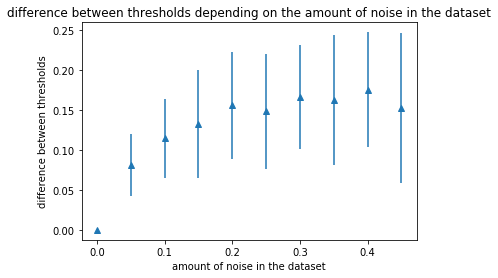

In [599]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

In [78]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and real threshold
avg_diff_1 = []
std_diff_1 = []

# difference between prdm threshold and real threshold
avg_diff_2 = []
std_diff_2 = []


start = time.time()

for i in noises:
    threshold_diff_1 = []
    threshold_diff_2 = []
    
    datasets = []
    
    for j in range(25):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        threshold_diff_1.append(fabs(threshold_r - 0))
            
        threshold_nr, entropy_nr = discretize(prdm, data_set, 0)
        
        threshold_diff_2.append(fabs(threshold_nr - 0))
        
    avg_diff_1.append(np.average(threshold_diff_1))
    std_diff_1.append(np.std(threshold_diff_1))

    avg_diff_2.append(np.average(threshold_diff_2))
    std_diff_2.append(np.std(threshold_diff_2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 562.5925226211548 s


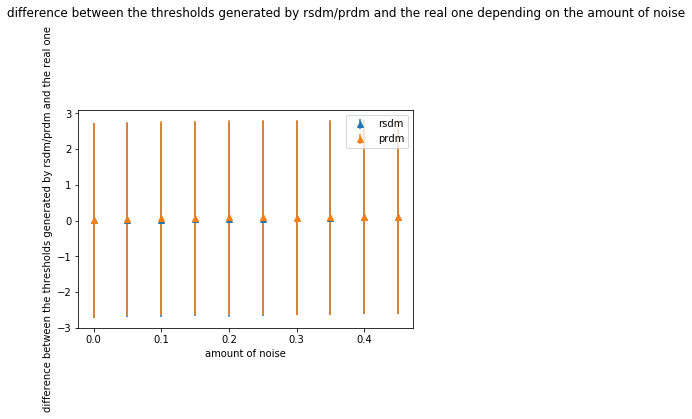

In [79]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='prdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the thresholds generated by rsdm/prdm and the real one")
plt.title("difference between the thresholds generated by rsdm/prdm and the real one depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

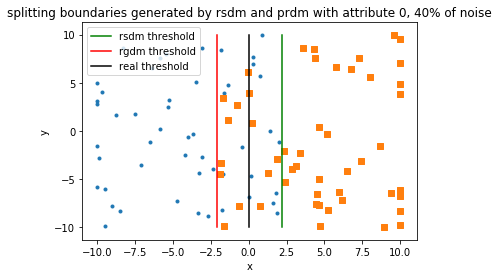

In [57]:
set2, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set2, 0)
t2, h2 = discretize(prdm, set2, 0)
display_discretizations_comparison(set2, t1, t2, thr, 0, "splitting boundaries generated by rsdm and prdm with attribute 0, 40% of noise", "rsdm threshold", "rgdm threshold")

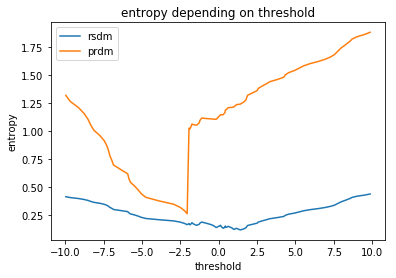

In [603]:
x, y1 = discretize_steps(rsdm, set2, 0)
x, y2 = discretize_steps(prdm, set2, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="prdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

splitting value generated by rsdm on axis 1 :  -0.731683209528744
splitting value generated by rgdm on axis 1 :  -0.731683209528744


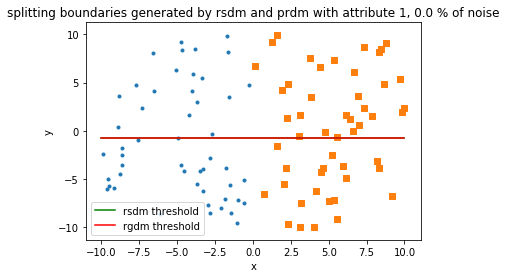

splitting value generated by rsdm on axis 1 :  -4.193855720839864
splitting value generated by rgdm on axis 1 :  -4.299041855015721


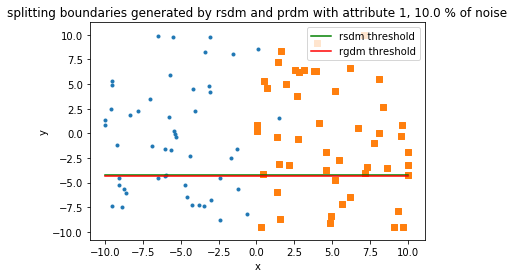

splitting value generated by rsdm on axis 1 :  -9.821374626699054
splitting value generated by rgdm on axis 1 :  9.500318562261075


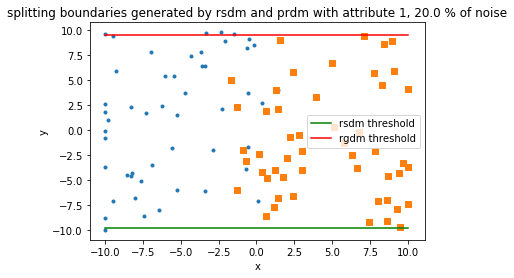

splitting value generated by rsdm on axis 1 :  8.161899839617199
splitting value generated by rgdm on axis 1 :  7.978486918806341


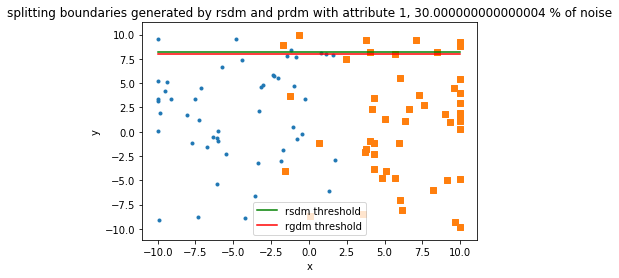

splitting value generated by rsdm on axis 1 :  6.5432417742031275
splitting value generated by rgdm on axis 1 :  2.042895931898336


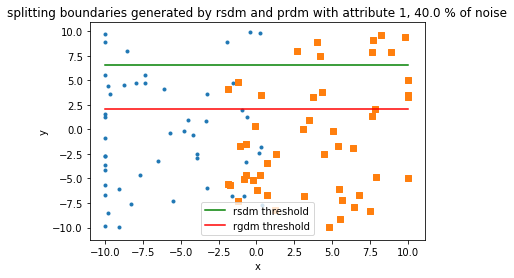

splitting value generated by rsdm on axis 1 :  0.8283408096188989
splitting value generated by rgdm on axis 1 :  0.8283408096188989


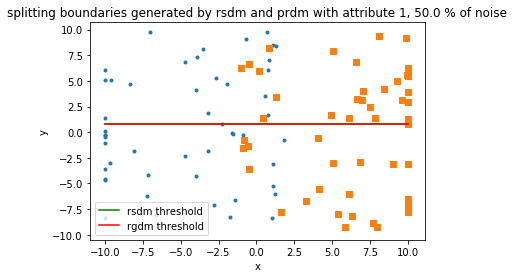

splitting value generated by rsdm on axis 1 :  5.74412289846085
splitting value generated by rgdm on axis 1 :  -7.211384827774039


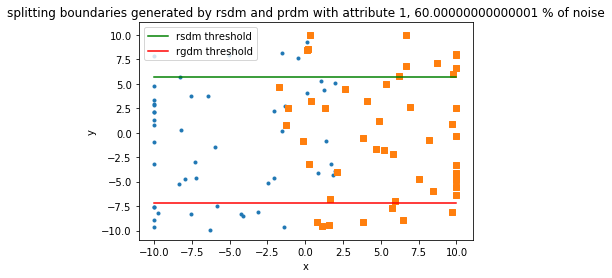

splitting value generated by rsdm on axis 1 :  -3.9742498786093274
splitting value generated by rgdm on axis 1 :  -3.9742498786093274


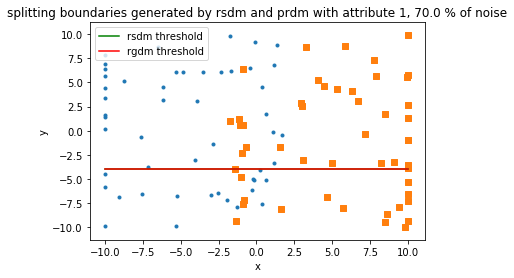

splitting value generated by rsdm on axis 1 :  -8.653786899741348
splitting value generated by rgdm on axis 1 :  -9.284321689873337


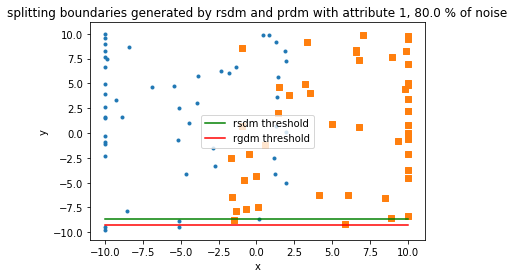

splitting value generated by rsdm on axis 1 :  1.2279551377707838
splitting value generated by rgdm on axis 1 :  -2.650303495495254


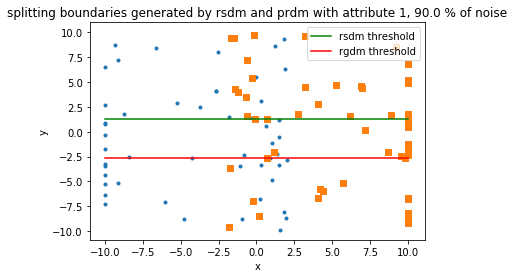

total run time : 6157.046373605728 s


In [604]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(prdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 50))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by prdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and prdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "prdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

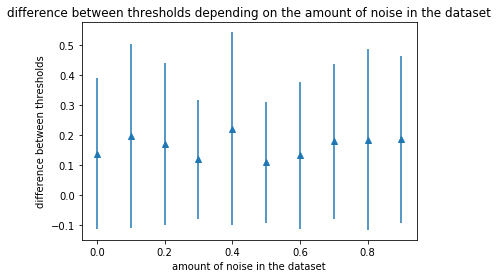

In [605]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

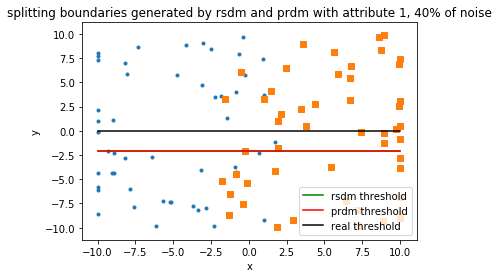

In [53]:
set2, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

t1, h1 = discretize(rsdm, set2, 1)
t2, h2 = discretize(prdm, set2, 1)
display_discretizations_comparison(set2, t1, t2, thr, 1, "splitting boundaries generated by rsdm and prdm with attribute 1, 40% of noise", "rsdm threshold", "prdm threshold")

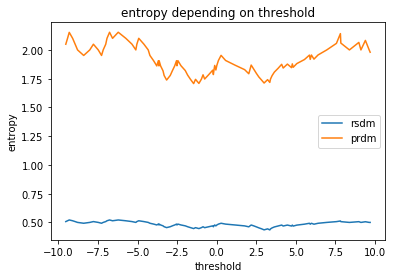

In [607]:
x, y1 = discretize_steps(rsdm, set2, 1)
x, y2 = discretize_steps(prdm, set2, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="prdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

## Comparaison des mesures *-dsr

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


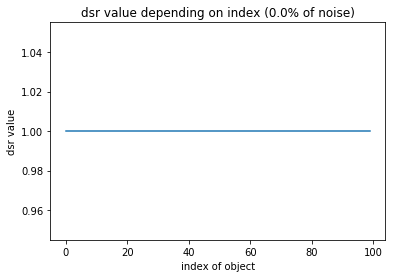

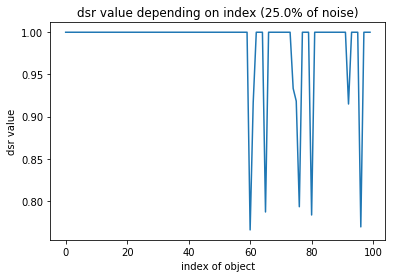

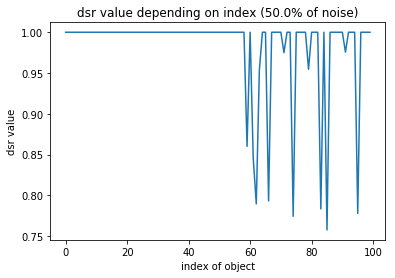

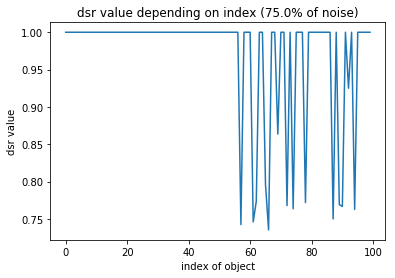

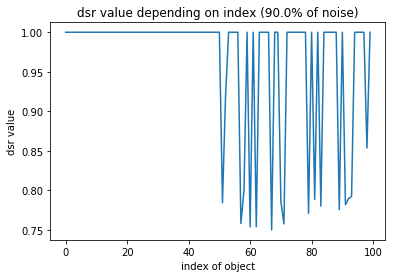

In [54]:
noises = [0., 0.25, 0.5, 0.75, 0.9]

for j in noises:
    data_set, t = generate_2Ddataset(0, 2, 100, j, 0.1, [[-10, 10], [-10, 10]])

    x = np.arange(data_set.size())

    dsr = Dsr()
    dsr_values = []
    dsa = dsr.dominant_sets_attribute(data_set, 0)
    dsl = dsr.dominant_sets_label(data_set)

    for i in range(0, data_set.size()):
        dsr_values.append(dsr.value(i, data_set, dsa, dsl, None))

    y = np.array(dsr_values)
    plt.plot(x, y)
    plt.ylabel("dsr value")
    plt.xlabel("index of object")
    plt.title("dsr value depending on index (" + str(j*100) + "% of noise)")
    plt.legend()
    plt.show()

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


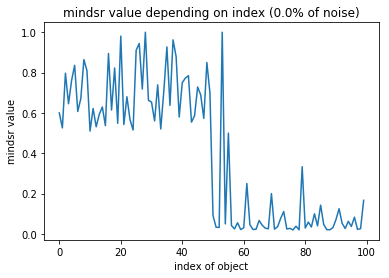

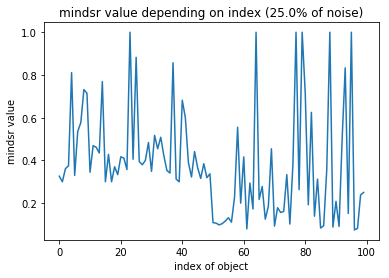

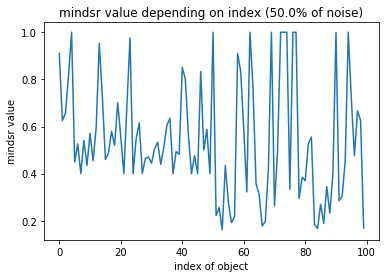

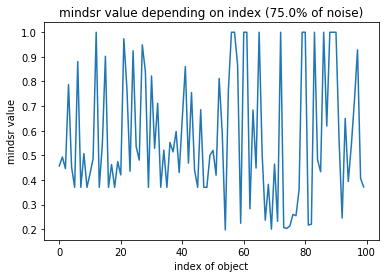

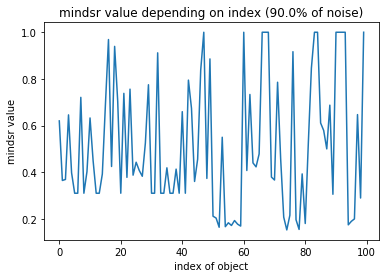

In [55]:
noises = [0., 0.25, 0.5, 0.75, 0.9]

for j in noises:
    data_set, t = generate_2Ddataset(0, 2, 100, j, 0.1, [[-10, 10], [-10, 10]])
    x = np.arange(data_set.size())

    dsr = Mindsr()
    dsr_values = []
    dsa = dsr.dominant_sets_attribute(data_set, 0)
    dsl = dsr.dominant_sets_label(data_set)
    esa = dsr.equal_sets_label(data_set)
    
    for i in range(0, data_set.size()):
        dsr_values.append(dsr.value(i, data_set, dsa, dsl, esa))

    y = np.array(dsr_values)
    plt.plot(x, y)
    plt.ylabel("mindsr value")
    plt.xlabel("index of object")
    plt.title("mindsr value depending on index (" + str(j*100) + "% of noise)")
    plt.legend()
    plt.show()

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


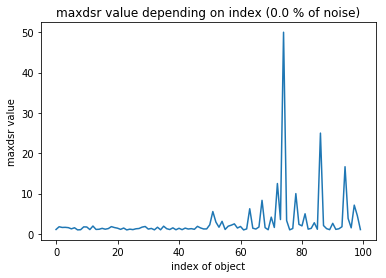

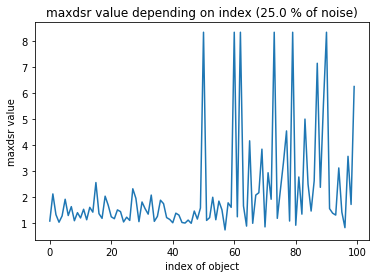

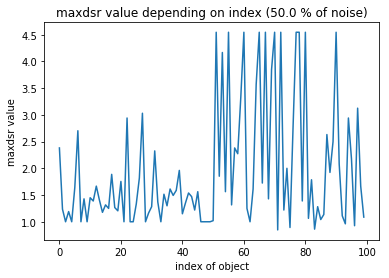

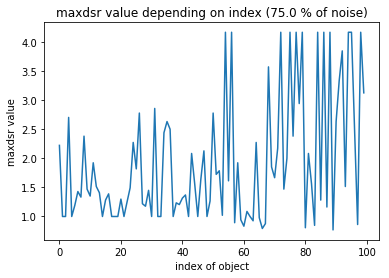

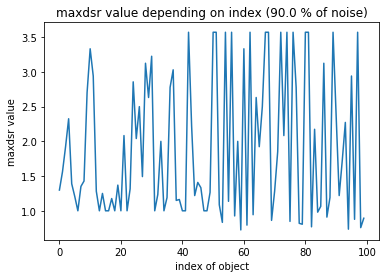

In [56]:
noises = [0., 0.25, 0.5, 0.75, 0.9]

for j in noises:
    data_set, t = generate_2Ddataset(0, 2, 100, j, 0.1, [[-10, 10], [-10, 10]])
    x = np.arange(data_set.size())

    dsr = Maxdsr()
    dsr_values = []
    dsa = dsr.dominant_sets_attribute(data_set, 0)
    dsl = dsr.dominant_sets_label(data_set)
    esa = dsr.equal_sets_label(data_set)
    
    for i in range(0, data_set.size()):
        dsr_values.append(dsr.value(i, data_set, dsa, dsl, esa))

    y = np.array(dsr_values)
    plt.plot(x, y)
    plt.ylabel("maxdsr value")
    plt.xlabel("index of object")
    plt.title("maxdsr value depending on index (" + str(j * 100) + " % of noise)")
    plt.legend()
    plt.show()

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


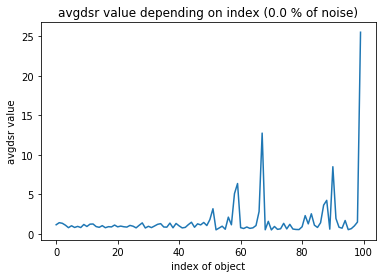

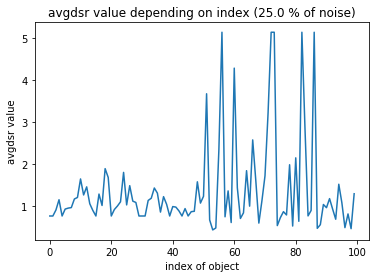

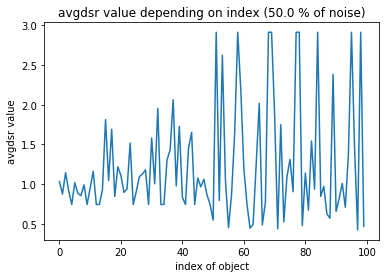

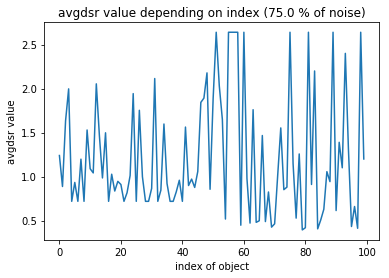

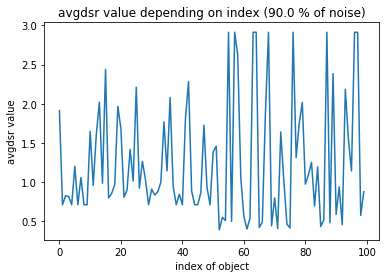

In [57]:
noises = [0., 0.25, 0.5, 0.75, 0.9]

for j in noises:
    data_set, t = generate_2Ddataset(0, 2, 100, j, 0.1, [[-10, 10], [-10, 10]])
    x = np.arange(data_set.size())

    dsr = Avgdsr()
    dsr_values = []
    dsa = dsr.dominant_sets_attribute(data_set, 0)
    dsl = dsr.dominant_sets_label(data_set)
    esa = dsr.equal_sets_label(data_set)
    
    for i in range(0, data_set.size()):
        dsr_values.append(dsr.value(i, data_set, dsa, dsl, esa))

    y = np.array(dsr_values)
    plt.plot(x, y)
    plt.ylabel("avgdsr value")
    plt.xlabel("index of object")
    plt.title("avgdsr value depending on index (" + str(j * 100) + " % of noise)")
    plt.legend()
    plt.show()